In [2]:
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

/upb/users/m/mengshim/profiles/unix/cs/miniconda3/envs/mengshi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_macro_f1(languages: set, f1_scores: dict, x_distance, figsize):
    x = np.arange(len(languages)) * x_distance  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)

    for attribute, measurement in f1_scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, fmt='%.2f')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores by languages')
    ax.set_xticks(x + width*(len(f1_scores)-1)/2, languages)
    ax.legend(loc='upper left', ncols=3)
    plt.show()


def get_lang_set(results):
    languages_list = [set(result["Language"].tolist())
                      for result in results.values()]
    return set().union(*languages_list)


def get_f1_scores(results, languages):
    f1_scores = {}
    for name, result_df in results.items():
        scores = list()
        for lang in languages:
            try:
                macro_f1 = result_df.loc[result_df["Language"]
                                         == lang, "Macro F1"].iloc[0]
            except:
                macro_f1 = 0
            scores.append(macro_f1)
        f1_scores[name] = scores
    return f1_scores

def plot(results, x_distance=1, figsize=(8, 8)):
    languages = get_lang_set(results)
    f1_scores = get_f1_scores(results, languages)
    plot_macro_f1(languages, f1_scores, x_distance, figsize)

In [4]:
qanswer = pd.read_csv("../previous_paper_results/QAnswer.csv")
platypus = pd.read_csv("../previous_paper_results/Platypus.csv")
deeppavlov = pd.read_csv("../previous_paper_results/DeepPavlov.csv")
sgpt = pd.read_csv("../previous_paper_results/sgpt.csv")
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306220013
baseline = pd.read_csv("../gerbil_results/mt5-base_11-new.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../gerbil_results/mt5-base_11-new.csv'

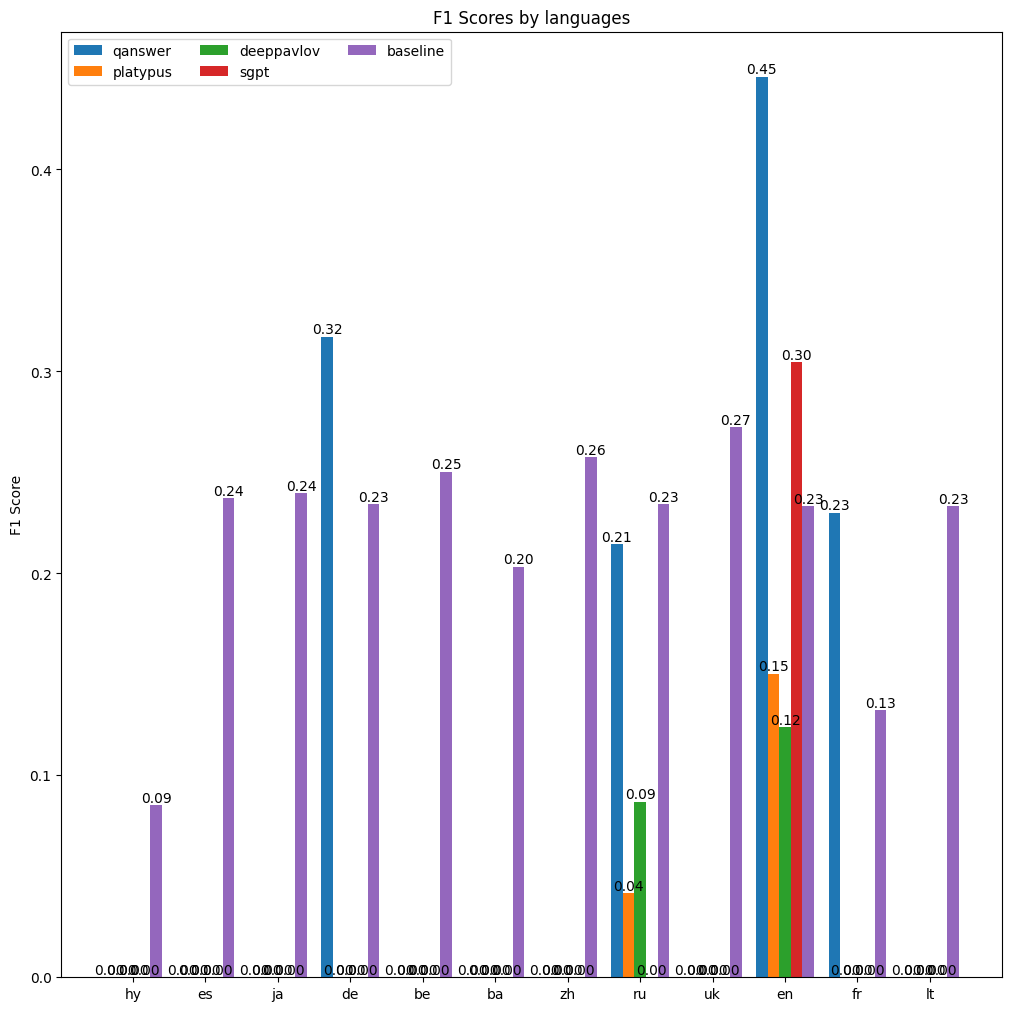

In [4]:
plot({
    "qanswer": qanswer,
    "platypus": platypus,
    "deeppavlov": deeppavlov,
    "sgpt": sgpt,
    "baseline": baseline
}, 
x_distance=2.5,
figsize=(10,10))

# Evaluation Results

After fine-tuning the models, we need to evaluate their performance. We use [GERBIL](https://gerbil-qa.aksw.org/gerbil/config) to calculate the F1 score of each model and language individually. We convert the questions in the test dataset to SPARQL queries, send them to [Wikidata Query Service](https://query.wikidata.org/) to get answers, and build a dataset in QALD format containing the infered SPARQL queries and answers. Then, we upload this file to GERBIL and evaluate it.

We conduct ablation studies using different models with different tokenizers. We fine-tune the models on the [QALD-9-plus](https://github.com/KGQA/QALD_9_plus) training dataset, a multilingual dataset that extends QALD-9 with more questions in nine languages and covers both DBpedia and Wikidata as knowledge graphs, and evaluate them on the test dataset. Since there are only european languages in the QALD-9-plus dataset, we also add Chinese and Japanese translations of questions to expand the coverage of languages for KGQA research and applications and enable multilingual KGQA models to learn from more diverse and rich data. As the QALD-9-Plus dataset incorporated Spanish questions only recently, some of our experiments might have excluded this language from both training and evaluation.

**Note that unless otherwise stated, all answers is limited to 50 results to avoid excessive file size.**

## Experiment 1

The first experiment aims to leverage a multilingual text-to-text transformer model called [mT5-base](https://huggingface.co/google/mt5-base) to answer natural language questions over linked data. 
The model is previously  pre-trained on a large-scale dataset called [LC-QuAD](https://github.com/AskNowQA/LC-QuAD) that contains over 5000 questions and their corresponding SPARQL queries for **16 epochs**. 
We also filter out entities and relations in LC-QuAD dataset and add them to mt5 tokenizer to improve tokenizing knowledge graph entities. This new tokenizer is trained on LC-QuAD training dataset. 

We fine-tuned a pre-trained language model on different datasets that contain varying numbers of languages with four settings: one-shot, few-shot, no-en, and all languages. 
- In the one-shot setting, we fine-tuned the model on only English questions. 
- In the few-shot setting, we fine-tuned the model on a small amount of languages. 
- In the no-en setting, we exclude English questions from dataset while including all other languages.
- In the all languages setting, we fine-tuned the model on all the available languages.

The experiment runs for **300 epochs** before evaluation.

### mT5 tokenizer + LC-QuAD tokens

First, we show you the results of the mT5 tokenizer on tokenizing SPARQL query. 
Note that these SPARQL queries are preprocessed to simplify tokenization and reduce syntax errors.

We take three example SPARQL queries. 

- Which instruments does Cat Stevens play?

In [62]:
query1 = "SELECT DISTINCT var_uri WHERE bra_open wd_Q154216 wdt_P1303 var_uri sep_dot bra_close"

- Is horse racing a sport?

In [63]:
query2 = "ASK WHERE bra_open wd_Q187916 wdt_P279* wd_Q349 sep_dot bra_close"

- Which states border Illinois?

In [64]:
query3 = "SELECT DISTINCT var_uri WHERE bra_open wd_Q1204 wdt_P47 var_uri sep_dot bra_close"

First, we show how mT5 tokenizer tokenizes SPARQL queries.

In [65]:
mt5_tokenizer = AutoTokenizer.from_pretrained("google/mt5-base")

/upb/users/m/mengshim/profiles/unix/cs/miniconda3/envs/mengshi/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [66]:
tokens = mt5_tokenizer.tokenize(query1)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁bra', '_', 'open', '▁w', 'd', '_', 'Q', '1542', '16', '▁w', 'd', 't', '_', 'P', '1303', '▁var', '_', 'uri', '▁sep', '_', 'dot', '▁bra', '_', 'close'], 

In [67]:
tokens = mt5_tokenizer.tokenize(query2)
print(tokens, end=", ")

['▁', 'ASK', '▁W', 'HERE', '▁bra', '_', 'open', '▁w', 'd', '_', 'Q', '1879', '16', '▁w', 'd', 't', '_', 'P', '279', '*', '▁w', 'd', '_', 'Q', '349', '▁sep', '_', 'dot', '▁bra', '_', 'close'], 

In [68]:
tokens = mt5_tokenizer.tokenize(query3)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁bra', '_', 'open', '▁w', 'd', '_', 'Q', '1204', '▁w', 'd', 't', '_', 'P', '47', '▁var', '_', 'uri', '▁sep', '_', 'dot', '▁bra', '_', 'close'], 

We see that entities and relations are tokenized as some single letters and numbers, therefore, the meaning of entities and relations is lost. 
We filter out entities and relations from LC-QuAD dataset to expand vocabulary of mT5 tokenizer. 

Now, we demonstrate the tokenization results of our new trained tokenizer. 

In [69]:
lcquad_tokenizer = AutoTokenizer.from_pretrained("../lcquad_tokenizer")

In [70]:
tokens = lcquad_tokenizer.tokenize(query1)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁', 'bra_open', '▁', 'wd_Q154', '▁216', '▁', 'wdt_P1303', '▁var', '_', 'uri', '▁', 'sep_dot', '▁', 'bra_close'], 

In [71]:
tokens = lcquad_tokenizer.tokenize(query2)
print(tokens, end=", ")

['▁', 'ASK', '▁W', 'HERE', '▁', 'bra_open', '▁', 'wd_Q18', '▁7', '916', '▁', 'wdt_P279', '▁*', '▁', 'wd_Q349', '▁', 'sep_dot', '▁', 'bra_close'], 

In [72]:
tokens = lcquad_tokenizer.tokenize(query3)
print(tokens, end=", ")

['▁', 'SELECT', '▁D', 'ISTI', 'NCT', '▁var', '_', 'uri', '▁W', 'HERE', '▁', 'bra_open', '▁', 'wd_Q1204', '▁', 'wdt_P47', '▁var', '_', 'uri', '▁', 'sep_dot', '▁', 'bra_close'], 

In this case, some entities and relations have been correctly tokenized. 
However, despite the inclusion of many tokens from LC-QuAD into the mT5 tokenizer, it still lacks the complete set of wikidata entities and relations. Consequently, some entities and relations remain incorrectly tokenized. 
The impact of adding entities and relations into a tokenizer on the tokenization quality of SPARQL queries for smaller knowledge graphs is yet to be determined.

### one-shot


We first fine-tune with only English questions, which takes least time for fine-tuning. 

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304030010

In [10]:
exp1_one_shot = pd.read_csv("../gerbil_results/mt5-base-lcquad_1.csv")
mask = exp1_one_shot['Language'].str.contains('en')
exp1_one_shot.style.apply(lambda x: ['background: yellow' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.000000,0.000000,0.000000,0.044100,0.044100,0.044100,0.084400
1,be,0.007000,0.332300,0.003600,0.092300,0.095300,0.090700,0.163200
2,de,0.005500,0.140100,0.002800,0.081900,0.082100,0.082200,0.147500
3,en,0.009400,0.221600,0.004800,0.174800,0.178500,0.177700,0.289100
4,fr,0.006700,0.795500,0.003400,0.077600,0.080600,0.076000,0.140900
5,hy,0.003100,0.252600,0.001500,0.041100,0.043800,0.039900,0.076700
6,ja,0.000400,0.021600,0.000200,0.070000,0.070100,0.069900,0.129300
7,lt,0.006600,0.217800,0.003400,0.077600,0.080600,0.076000,0.140200
8,ru,0.003900,0.114800,0.002000,0.079300,0.081700,0.084600,0.151000
9,uk,0.008100,0.207500,0.004100,0.066600,0.074600,0.063900,0.117500


The results of this experiment show that English has the best performance among the languages tested. The other languages, such as `ba` and `hy`, have much lower scores. This suggests that the model is more suited for English than for other languages, and that more data and fine-tuning are needed to improve its performance on other languages.

### four-shot 

We experiment with four languages of questions: en, de, zh, and ru.

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304250003

In [11]:
exp1_four_shot = pd.read_csv("../gerbil_results/mt5-base-lcquad_4.csv")
def highlight_language(row):
    if row['Language'] in ['en', 'de', 'zh', 'ru']:
        return ['background-color: yellow']*len(row)
    else:
        return ['']*len(row)
exp1_four_shot.style.apply(highlight_language, axis=1)

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.004000,0.331600,0.002000,0.089700,0.093800,0.088700,0.160700
1,be,0.008600,0.174100,0.004400,0.107200,0.113700,0.105500,0.183900
2,de,0.008800,0.193200,0.004500,0.129900,0.136300,0.128100,0.217300
3,en,0.008900,0.222000,0.004500,0.151800,0.158200,0.150000,0.250200
4,fr,0.006700,0.586600,0.003400,0.077500,0.080400,0.076100,0.141200
5,hy,0.003400,0.335400,0.001700,0.048400,0.051000,0.047200,0.090100
6,ja,0.008800,0.194400,0.004500,0.114600,0.121300,0.112900,0.196100
7,lt,0.009100,0.192900,0.004700,0.097100,0.109700,0.097100,0.172900
8,ru,0.009400,0.210400,0.004800,0.141600,0.146800,0.142500,0.238700
9,uk,0.008600,0.153200,0.004400,0.115000,0.121500,0.113200,0.194400


The experiment also reveals that the languages that are included in the training dataset have better performance than the languages that are not. This indicates that the model can learn from the multilingual data and generalize to similar languages. However, the F1 score of English is lower than the one-shot baseline, which means that the model does not benefit from the additional data for other languages and may suffer from interference from other languages.

### all languages (11)

In all languages setting, we include en, de, zh, ja, ru, fr, hy, ba, be, uk, lt. 
`es` is not included since our Spanish translation of questions is merged later than this experiment.

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304250001

In [6]:
exp1_all = pd.read_csv("../gerbil_results/mt5-base-lcquad_11.csv")
exp1_all

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0044,0.2438,0.0022,0.1266,0.1307,0.1256,0.2157
1,be,0.0103,0.2195,0.0053,0.1316,0.1394,0.1293,0.2178
2,de,0.0091,0.2117,0.0047,0.1666,0.1731,0.1648,0.2700
3,en,0.0088,0.1796,0.0045,0.1373,0.1510,0.1355,0.2275
4,fr,0.0067,0.7000,0.0034,0.0775,0.0804,0.0761,0.1412
5,hy,0.0035,0.4320,0.0017,0.0631,0.0657,0.0619,0.1165
6,ja,0.0091,0.2362,0.0047,0.1403,0.1460,0.1402,0.2338
7,lt,0.0102,0.2414,0.0052,0.1260,0.1319,0.1248,0.2145
8,ru,0.0089,0.2319,0.0045,0.1446,0.1582,0.1427,0.2376
9,uk,0.0089,0.1759,0.0046,0.1519,0.1584,0.1501,0.2469


The results show that German has the best performance among all the languages. On the other hand, French and Armenian have the worst performance. The other languages do not show any obvious difference in their performance.

### no-en

We exclude English question to test the influence on English performance. 

result: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304250002

In [7]:
exp1_no_en = pd.read_csv("../gerbil_results/mt5-base-lcquad_no-en.csv")
mask = exp1_one_shot['Language'].str.contains('en')
exp1_one_shot.style.apply(lambda x: ['background: #00ccff' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.000000,0.000000,0.000000,0.044100,0.044100,0.044100,0.084400
1,be,0.007000,0.332300,0.003600,0.092300,0.095300,0.090700,0.163200
2,de,0.005500,0.140100,0.002800,0.081900,0.082100,0.082200,0.147500
3,en,0.009400,0.221600,0.004800,0.174800,0.178500,0.177700,0.289100
4,fr,0.006700,0.795500,0.003400,0.077600,0.080600,0.076000,0.140900
5,hy,0.003100,0.252600,0.001500,0.041100,0.043800,0.039900,0.076700
6,ja,0.000400,0.021600,0.000200,0.070000,0.070100,0.069900,0.129300
7,lt,0.006600,0.217800,0.003400,0.077600,0.080600,0.076000,0.140200
8,ru,0.003900,0.114800,0.002000,0.079300,0.081700,0.084600,0.151000
9,uk,0.008100,0.207500,0.004100,0.066600,0.074600,0.063900,0.117500


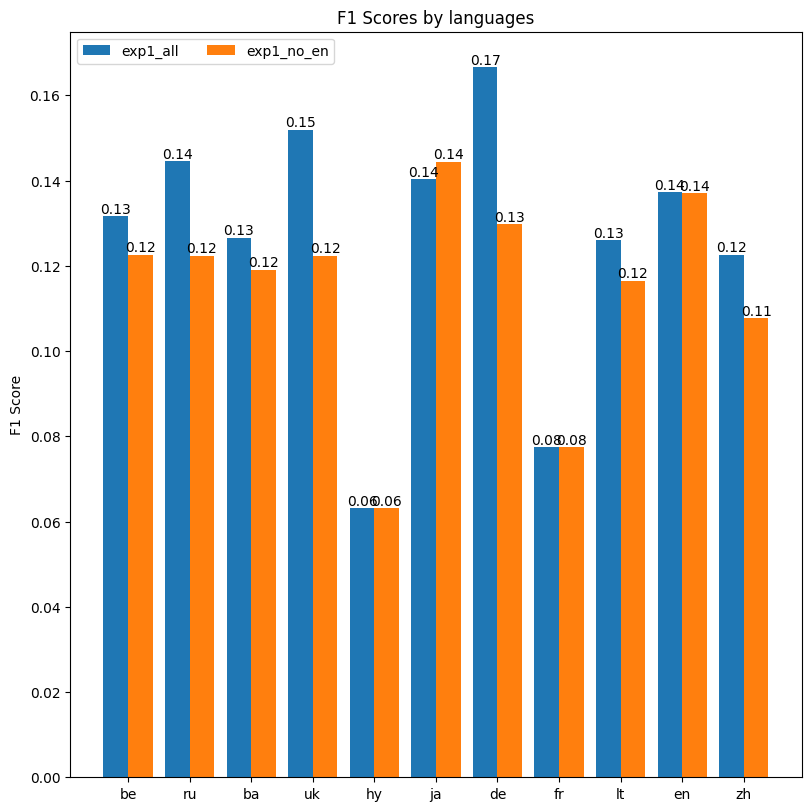

In [47]:
results = {
    "exp1_all": exp1_all,
    "exp1_no_en": exp1_no_en
}

plot(results)

The results show that almost all performance is worse than with English questions, indicating that the cross-lingual transfer is not very effective. The only exception is `ja`, which is improved slightly. However, this improvement is not significant when compared to the performance without English questions, suggesting that the English questions do not provide much benefit for the Japanese language.

Now we compare all settings in Experiment 1

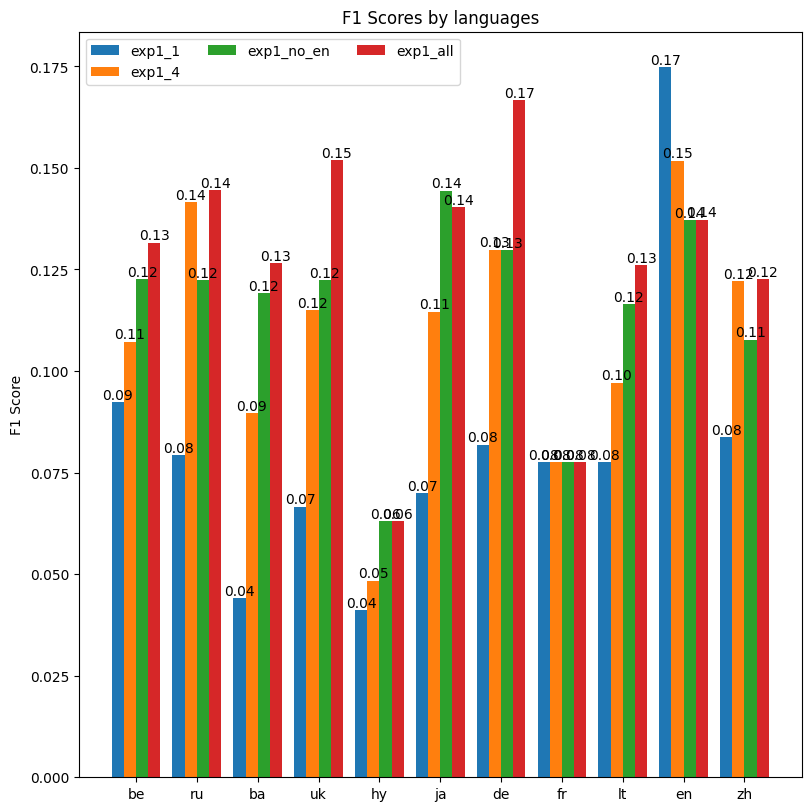

In [48]:
results = {
    "exp1_1": exp1_one_shot,
    "exp1_4": exp1_four_shot,
    "exp1_no_en": exp1_no_en,
    "exp1_all": exp1_all
}

plot(results, x_distance=2)

Based on the information presented in the chart, it can be observed that the F1 Score for the English language experiences a consistent decrease, while the F1 scores for other languages demonstrate an upward trend. This finding leads us to suggest that the inclusion of additional languages in the dataset may have an adverse effect on the accuracy of English language inference, while conversely benefiting the accuracy of other languages by providing additional training data. It is noteworthy that the F1 score for French language inference remains relatively stable throughout Experiment 1. Furthermore, it is important to note that a lack of English training data may also negatively impact the accuracy of other languages.

## Experiment 2

In the second experiment, we try google/mt5-base model with mT5 tokenizer **without any pretraining on LC-QuAD dataset** to observe whether pretraining on LC-QuAD and adding tokens to tokenizer improve the performance. 

Furthermore, the experiment is run for 300 epochs prior to evaluation.

### one-shot

First, we try with only English questions.

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304050000

In [49]:
exp2_one_shot = pd.read_csv("../gerbil_results/mt5_1.csv")
mask = exp2_one_shot['Language'].str.contains('en')
exp2_one_shot.style.apply(lambda x: ['background: yellow' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.000100,0.003900,0.000000,0.051500,0.051500,0.051500,0.097100
1,be,0.004600,0.129900,0.002300,0.086000,0.093400,0.085400,0.152400
2,de,0.008800,0.151900,0.004600,0.115200,0.128900,0.111200,0.189000
3,en,0.009800,0.219300,0.005000,0.218500,0.232400,0.214300,0.320700
4,fr,0.006400,0.606100,0.003200,0.065000,0.073200,0.062500,0.117500
5,hy,0.003100,0.872700,0.001500,0.048500,0.051200,0.047300,0.090200
6,ja,0.003200,0.074100,0.001600,0.055400,0.065700,0.052100,0.096300
7,lt,0.006300,0.147700,0.003200,0.050300,0.058500,0.048000,0.090300
8,ru,0.004900,0.093600,0.002500,0.100700,0.108600,0.100100,0.172400
9,uk,0.004600,0.094100,0.002300,0.056700,0.064500,0.062100,0.113900


In Experiment 2, the F1 Score for English is higher than that of the one-shot setting in Experiment 1, indicating an improved performance for this language. However, the performance for all other languages, except for German and Russian, is found to be inferior to Experiment 1. 

### four-shot

We also choose `en`, `de`, `zh`, and `ru` for four-shot training.

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304040000

In [50]:
exp2_four_shot = pd.read_csv("../gerbil_results/mt5_4.csv")
exp2_four_shot.style.apply(highlight_language, axis=1)

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.004500,0.202300,0.002300,0.126700,0.134200,0.125600,0.211600
1,be,0.009600,0.183500,0.004900,0.148900,0.159300,0.151400,0.227000
2,de,0.009800,0.170800,0.005100,0.206200,0.217700,0.203300,0.282100
3,en,0.009600,0.134000,0.005000,0.191500,0.203000,0.188600,0.259600
4,fr,0.006800,0.540800,0.003400,0.077500,0.080400,0.076100,0.140900
5,hy,0.003700,0.311800,0.001900,0.057900,0.059700,0.059500,0.111900
6,ja,0.008200,0.190400,0.004200,0.143000,0.152600,0.139600,0.214400
7,lt,0.008800,0.195600,0.004500,0.134000,0.142800,0.131100,0.211000
8,ru,0.009500,0.131300,0.004900,0.154800,0.166400,0.151800,0.223600
9,uk,0.009400,0.142100,0.004800,0.166400,0.176600,0.166100,0.239100


It has been found that the F1 score decreases slightly for `en`. However, it improves significantly for other languages that are already present in the training dataset. Interestingly, the F1 score also tends to increase significantly for languages like `ja`, which have linguistic connections to `zh`, and `ba`, `be`, and `uk`, which have linguistic connections to `ru` . These findings suggest that training models with linguistically related languages may enhance the overall performance of the model.

### all languages (11)

We also fine-tuned for all 11 languages. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304080000

In [52]:
exp2_all = pd.read_csv("../gerbil_results/mt5_11.csv")
exp2_all

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0056,0.1589,0.0029,0.1571,0.1628,0.1557,0.2457
1,be,0.0098,0.1442,0.0051,0.1986,0.2171,0.1956,0.2704
2,de,0.0099,0.1477,0.0051,0.1962,0.2137,0.1920,0.2634
3,en,0.0099,0.1439,0.0051,0.1914,0.2134,0.1884,0.2585
4,es,0.0100,0.1481,0.0052,0.2059,0.2137,0.2035,0.2787
5,fr,0.0068,0.5354,0.0034,0.0775,0.0804,0.0761,0.1408
6,hy,0.0034,0.1957,0.0017,0.0558,0.0584,0.0546,0.1030
7,ja,0.0104,0.1583,0.0054,0.1966,0.2052,0.1945,0.2625
8,lt,0.0104,0.1307,0.0054,0.1900,0.2089,0.1854,0.2641
9,ru,0.0104,0.1369,0.0054,0.1775,0.1907,0.1742,0.2393


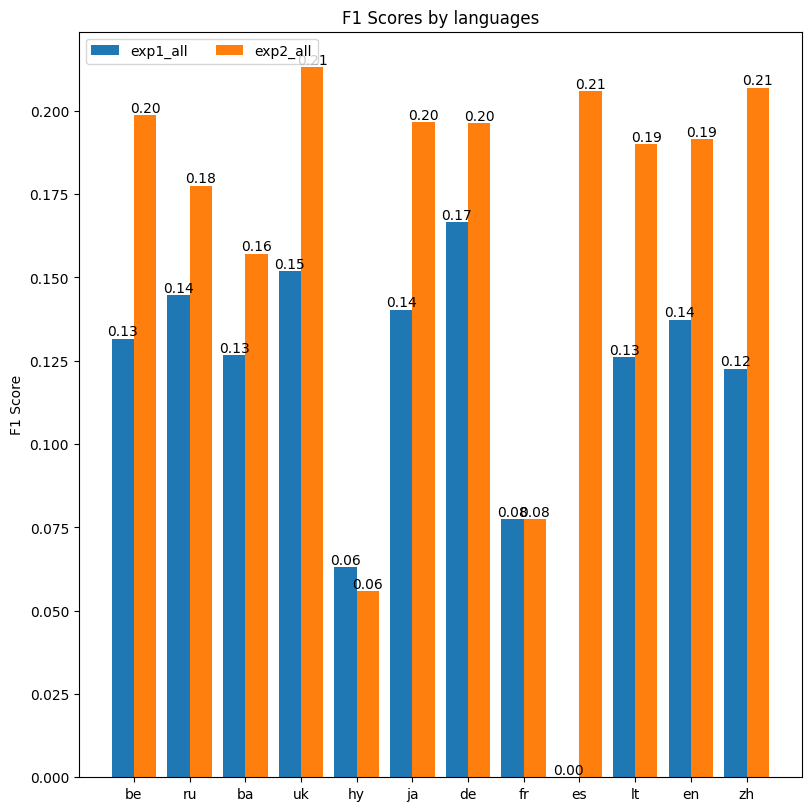

In [53]:
results = {
    "exp1_all": exp1_all,
    "exp2_all": exp2_all
}

plot(results)

The F1 scores for all languages except `hy` are higher than all languages setting in Experiment 1. For `zh`, the F1 Score is increased by 8.43.

To know how the F1 Score decreases with limitation of 50 results, we generate a qald file **without limitation**. Fortunatly, these files are not very large. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304080001

In [11]:
exp2_all_wo_limit = pd.read_csv("../gerbil_results/mt5_11-all.csv")
exp2_all_wo_limit

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0047,0.0116,0.0030,0.1573,0.1625,0.1563,0.2457
1,be,0.0071,0.0064,0.0080,0.2164,0.2316,0.2151,0.2852
2,de,0.0079,0.0077,0.0080,0.2139,0.2280,0.2115,0.2828
3,en,0.0072,0.0066,0.0081,0.2093,0.2280,0.2083,0.2749
4,es,0.0066,0.0055,0.0082,0.2237,0.2283,0.2234,0.2950
5,fr,0.0111,0.4137,0.0056,0.0880,0.0877,0.0882,0.1613
6,hy,0.0060,0.0144,0.0038,0.0660,0.0659,0.0662,0.1235
7,ja,0.0069,0.0059,0.0083,0.2144,0.2198,0.2140,0.2761
8,lt,0.0076,0.0071,0.0083,0.1931,0.2087,0.1902,0.2650
9,ru,0.0070,0.0060,0.0083,0.1953,0.2051,0.1938,0.2553


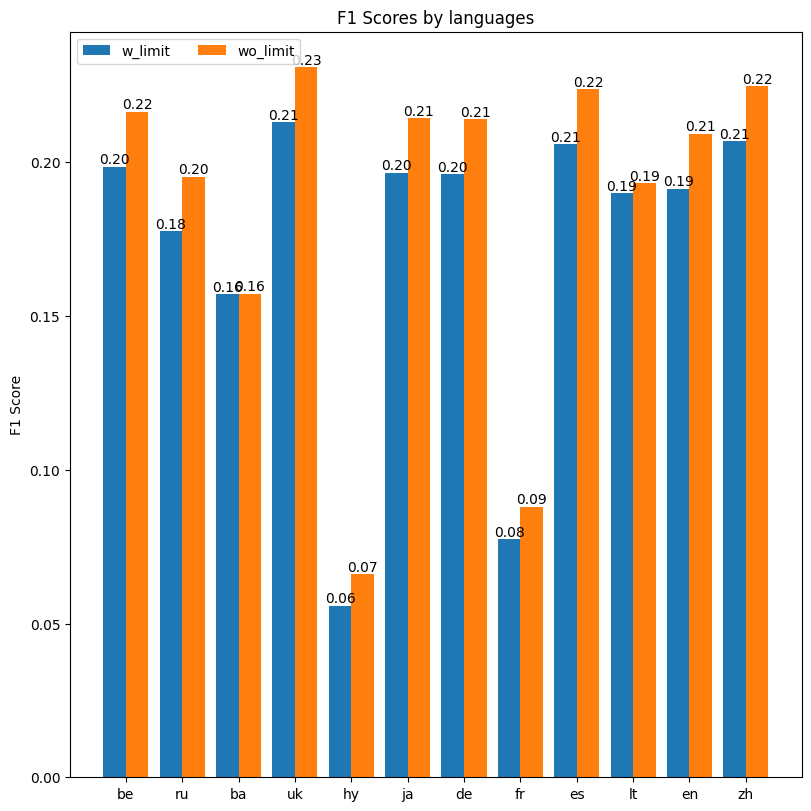

In [55]:
results = {
    "w_limit": exp2_all,
    "wo_limit": exp2_all_wo_limit
}

plot(results)

The macro F1 Score is improved about 0 to 2 depending on language without limitation.

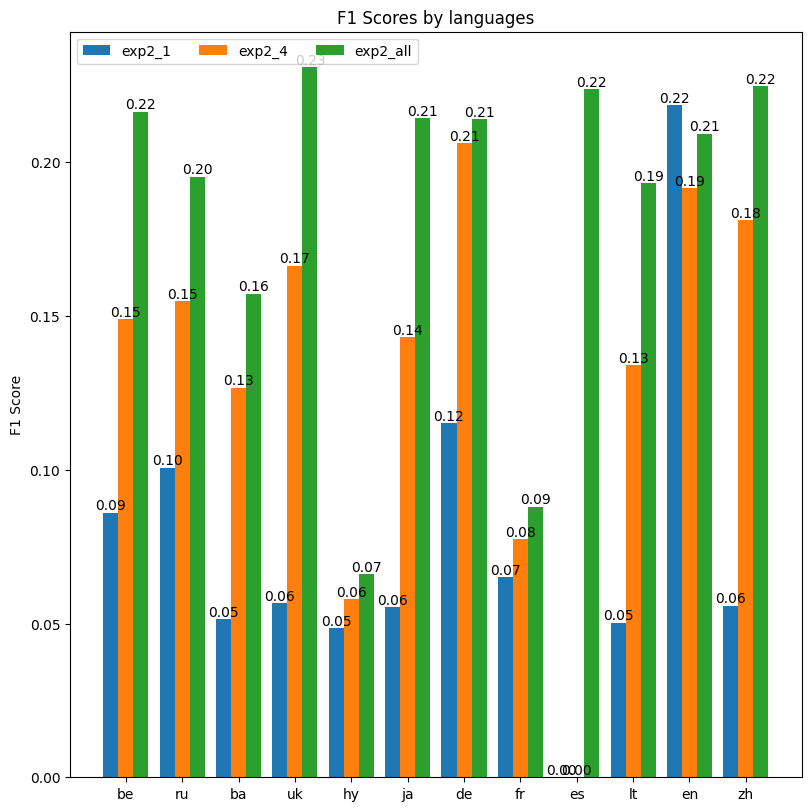

In [58]:
plot({
    "exp2_1": exp2_one_shot,
    "exp2_4": exp2_four_shot,
    "exp2_all": exp2_all_wo_limit
}, x_distance=1.5)

In Experiment 2 all languages setting, we observed a significant improvement in the performance of our model for all languages. Nine of the twelve languages reached a F1 score above 0.19. However, French and Hungarian still performed worst among the languages, suggesting that they might require more data or a different approach. The results of Experiment 2 clearly surpassed those of Experiment 1, demonstrating the effectiveness of this method.

The results of Experiment 1 and 2 indicate that the one-shot setting achieves the highest F1 Score for `en`. This suggests that multilingual fine-tuning has a negative impact on the performance of a single language. However, in a multilingual KGQA system, the performance of other languages is also relevant. As the number of languages in the training dataset increases, so does the average F1 Score.

## Experiment 3

In this experiment, we want to figure out whether **the mT5 tokenizer with LC-QuAD tokens** really improves the performance. Hence, we use the **mT5-base model** without pretraining on LC-QuAD from Experiment 2, but use the same tokenizer as in Experiment 1. 

The experiment is run for 300 epochs prior to evaluation.

### one-shot

We first try with the one-shot setting, fine-tune with only English questions. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304050004

In [59]:
exp3_one_shot = pd.read_csv("../gerbil_results/mt5-lcquadtokenizer_1.csv")
mask = exp3_one_shot['Language'].str.contains('en')
exp3_one_shot.style.apply(lambda x: ['background: yellow' if mask.iloc[i] else '' for i in range(len(mask))])

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.003200,0.193200,0.001600,0.058500,0.058800,0.058100,0.108900
1,be,0.008600,0.185400,0.004400,0.110700,0.121300,0.109100,0.189200
2,de,0.008200,0.181300,0.004200,0.100500,0.107200,0.098600,0.171000
3,en,0.009100,0.241600,0.004600,0.166600,0.172600,0.166200,0.271800
4,fr,0.006700,0.360800,0.003400,0.077600,0.080600,0.076000,0.140700
5,hy,0.000000,0.000000,0.000000,0.036800,0.036800,0.036800,0.070700
6,ja,0.003800,0.169000,0.001900,0.088600,0.095600,0.087900,0.156900
7,lt,0.007100,0.172800,0.003600,0.079300,0.086100,0.077100,0.140600
8,ru,0.007700,0.211100,0.003900,0.112200,0.123600,0.108800,0.188200
9,uk,0.008500,0.164800,0.004400,0.103400,0.121600,0.100300,0.174900


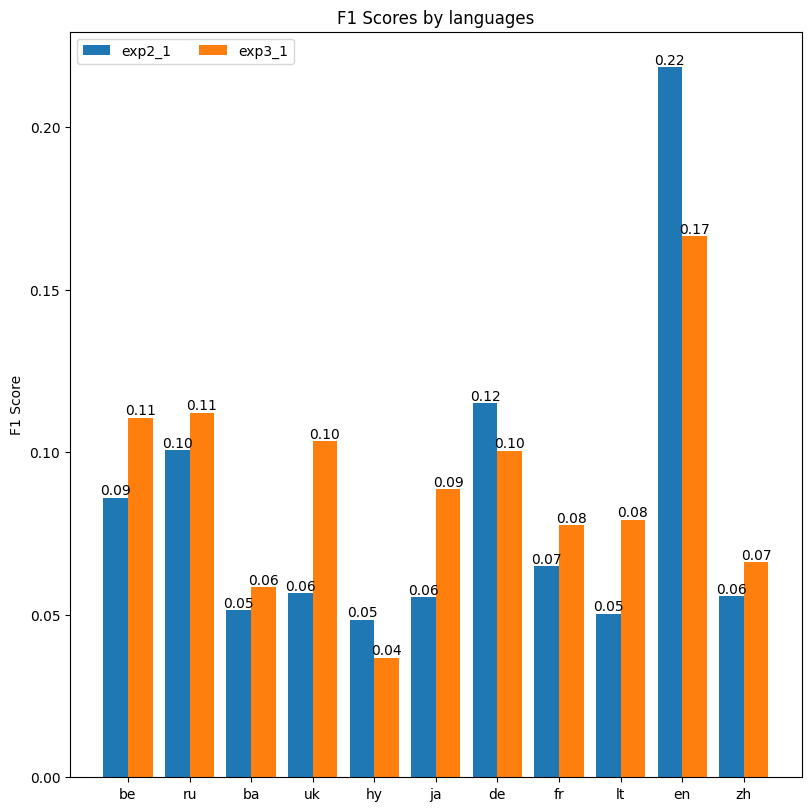

In [60]:
plot({
    "exp2_1": exp2_one_shot,
    "exp3_1": exp3_one_shot
})

The results show that only `de`, `en`, and `hy` have a lower F1 score than in Experiment 2 one-shot setting. 

### four-shot

Then, we try a four-shot setting, fine-tune with questions in `en`, `de`, `zh`, `ru`

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304050001

In [61]:
exp3_four_shot = pd.read_csv("../gerbil_results/mt5-lcquadtokenizer_4.csv")
exp3_four_shot.style.apply(highlight_language, axis=1)

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.003900,0.202000,0.002000,0.089700,0.093800,0.088700,0.159100
1,be,0.008300,0.142100,0.004300,0.107100,0.113500,0.105400,0.181900
2,de,0.008900,0.173600,0.004600,0.151300,0.157800,0.149600,0.240600
3,en,0.008900,0.172500,0.004600,0.159100,0.165300,0.164200,0.257800
4,fr,0.006700,0.795500,0.003400,0.077500,0.080400,0.076100,0.141100
5,hy,0.003400,0.530000,0.001700,0.055800,0.058400,0.054600,0.103400
6,ja,0.008600,0.203600,0.004400,0.121800,0.128100,0.120100,0.204100
7,lt,0.008600,0.156800,0.004400,0.092500,0.099200,0.090800,0.159500
8,ru,0.008700,0.209400,0.004400,0.122000,0.135600,0.120200,0.202900
9,uk,0.008700,0.189300,0.004400,0.129100,0.135600,0.127400,0.213500


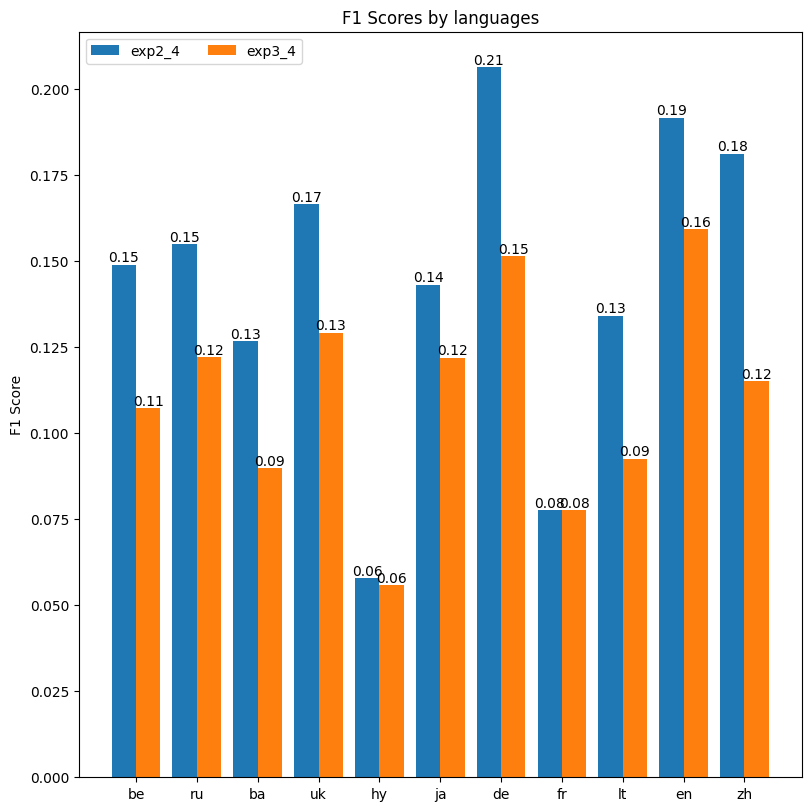

In [62]:
plot({
    "exp2_4": exp2_four_shot,
    "exp3_4": exp3_four_shot
})

As the number of languages in the training set increases, the F1 score for all languages in Experiment 2 four-shot setting is higher than in Experiment 3. This suggests that the language model leverages tokens in the tokenizer when the training dataset is small. However, when the training dataset is large, the language model learns the entity and relation information by itself and the performance is better than using a pre-trained tokenizer. Furthermore, the added tokens are not trained enough only on LC-QuAD dataset. 

## Experiment 4

In this experiment, We use mT5-base and the mT5 tokenizer as in the Experiment 2, since this configuration achieves the best performance. The input data consisted of natural language questions with part-of-speech tags, dependency relations, and dependency levels as additional linguistic features. The idea of using these features was inspired by [SGPT](https://arxiv.org/abs/2202.08904). We train the model for 300 epochs as in previous experiments. 

We enhance the question string with **additional linguistic features**, such as *part-of-speech tags, dependency relations, and dependency levels*, to facilitate the language model's comprehension of the question.

Here, we give some examples of question with linguistic context:

In [90]:
pd.set_option('max_colwidth', 1000)
pd.read_csv("../datasets/11_linguistic/q9pp_train.csv").question.head(3)

0               List all boardgames by GMT . <pad> VERB DET NOUN ADP PROPN PUNCT <pad> ROOT det dobj prep pobj punct <pad> 1 3 2 3 4 2
1     Liste die Brettspiele von GMT auf . <pad> NOUN DET NOUN ADP PROPN ADP PUNCT <pad> ROOT nk oa pg nk svp punct <pad> 1 3 2 3 4 2 2
2    Zeige mir alle Brettspiele von GMT . <pad> VERB PRON DET NOUN ADP PROPN PUNCT <pad> ROOT da nk oa pg nk punct <pad> 1 2 3 2 3 4 2
Name: question, dtype: object

### all languages (11)

We include `en`, `de`, `zh`, `ja`, `ru`, `fr`, `ba`, `be`, `uk`, `lt`, and `es`. 
There is no spacy model for Armenian, therefore Armenian is excluded in this experiment. 

results: https://gerbil-qa.aksw.org/gerbil/experiment?id=202304170000

In [14]:
exp4_all = pd.read_csv("../gerbil_results/mt5_11-ling.csv")
exp4_all

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0066,0.1858,0.0034,0.1590,0.1682,0.1571,0.2498
1,be,0.0101,0.1567,0.0052,0.2133,0.2245,0.2114,0.2851
2,de,0.0101,0.1397,0.0053,0.2253,0.2392,0.2212,0.2939
3,en,0.0103,0.1515,0.0053,0.2432,0.2543,0.2433,0.3200
4,es,0.0100,0.1450,0.0052,0.2353,0.2467,0.2335,0.3161
5,fr,0.0067,0.4380,0.0034,0.0849,0.0878,0.0835,0.1531
6,ja,0.0099,0.1660,0.0051,0.2008,0.2098,0.2047,0.2832
7,lt,0.0095,0.1350,0.0049,0.2179,0.2312,0.2138,0.2988
8,ru,0.0099,0.1348,0.0052,0.2130,0.2243,0.2102,0.2775
9,uk,0.0101,0.1349,0.0052,0.2424,0.2537,0.2396,0.3019


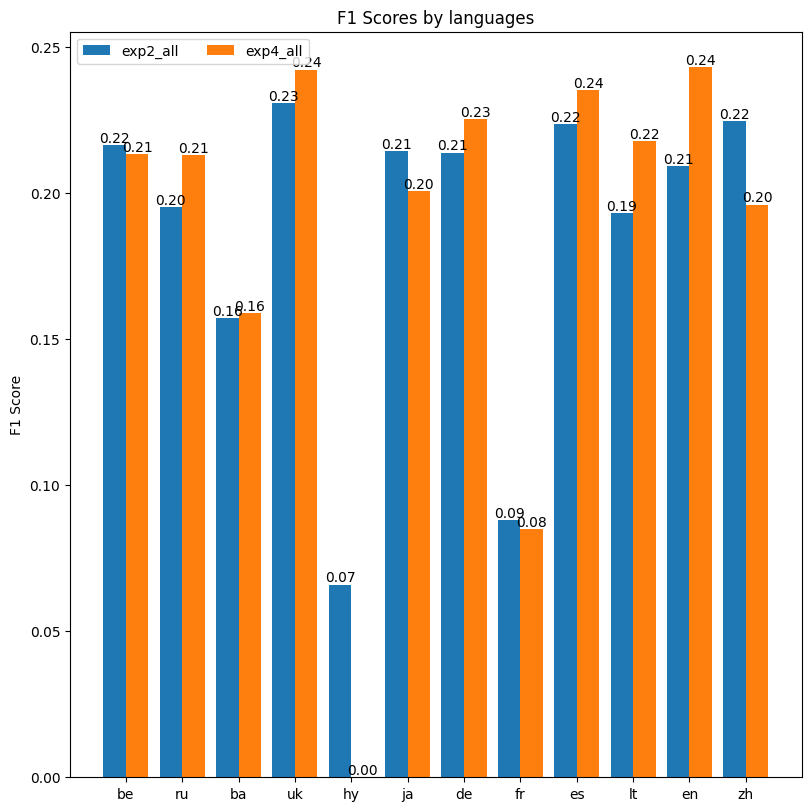

In [64]:
plot({
    "exp2_all": exp2_all_wo_limit,
    "exp4_all": exp4_all
})

According to the chart, we observe a significant improvement in the F1 score of most languages. In the case of other languages, their F1 scores are still comparable to the outcomes observed in Experiment 2. Remarkably, English achieved a noteworthy increase in its F1 score by 3.3, indicating a substantial improvement.

## Comparison to other works

According to KGQA leaderboard, there are some multilingual KGQA systems. We compare our best results by now to them. Also, we take our all-language setting as the baseline for our experiments.

In [65]:
qanswer = pd.read_csv("../previous_paper_results/QAnswer.csv")
platypus = pd.read_csv("../previous_paper_results/Platypus.csv")
deeppavlov = pd.read_csv("../previous_paper_results/DeepPavlov.csv")

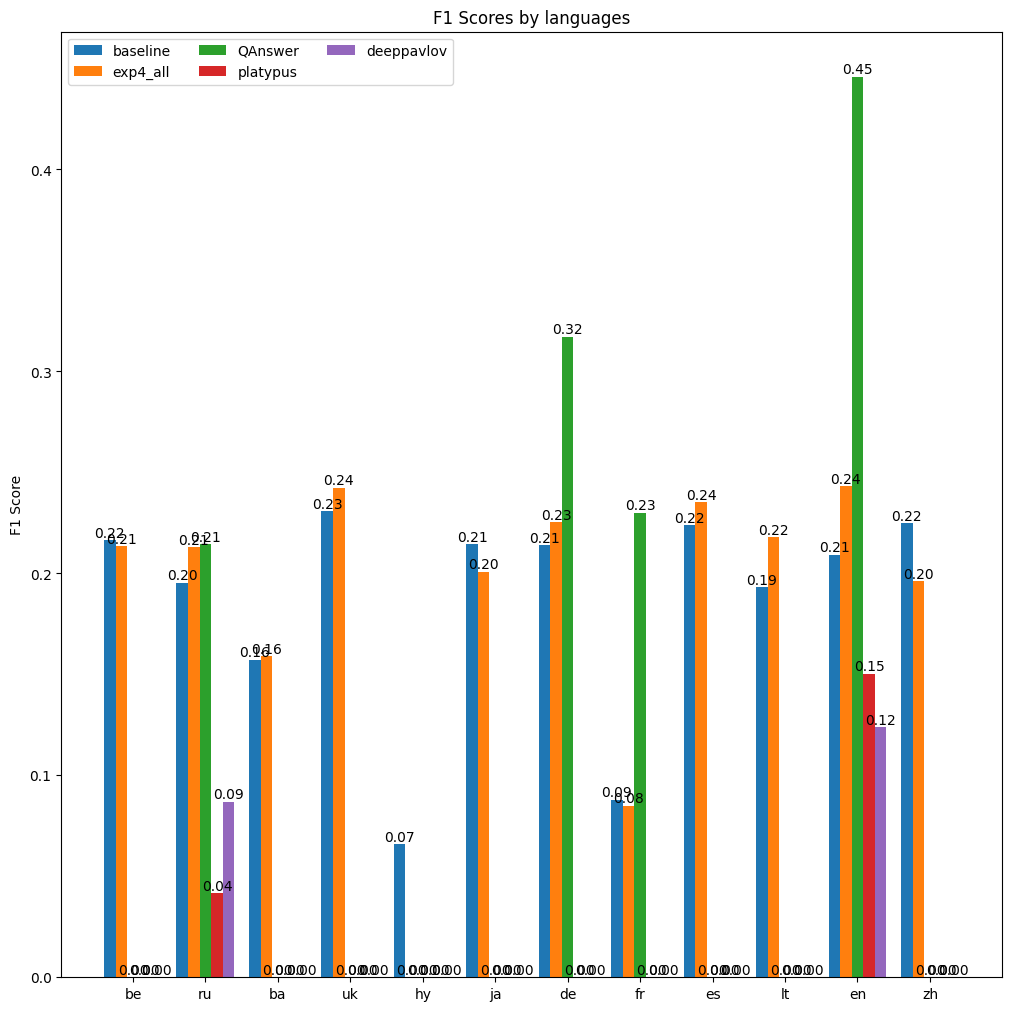

In [68]:
plot({
    "baseline": exp2_all_wo_limit,
    "exp4_all": exp4_all,
    "QAnswer": qanswer,
    "platypus": platypus,
    "deeppavlov": deeppavlov
}, x_distance=2.5, figsize=(10,10))

We take the experiment 2 all language setting as our baseline. 

Currently, the [KGQA leaderboard](https://kgqa.github.io/leaderboard/dbpedia/qald.html#qald-9-plus) indicates that [QAnswer](https://link.springer.com/chapter/10.1007/978-3-030-49461-2_25) outperforms other systems. QAnswer is capable of supporting multiple languages, namely en, de, fr, it, es, pt, nl, zh, ar, ja, and ru. It is noteworthy that we have not obtained the test data for the languages, namely it, es, pt, nl, and ar, which prevents us from evaluating the performance of QAnswer on these languages. Additionally, the zh, ja, and es translation of questions were not available when QAnswer was assessed on the QALD-9-Plus dataset, hence the evaluation results are limited to en, de, ru, and fr. 

Based on the available results, it is evident that QAnswer has demonstrated superior performance in all available languages, while our approach only appears to be competitive in ru.

## Experiment 5

fine-tune mT5-xl(3.7B) on qald 9 plus English questions without linguistic context for 100 epochs. 

### one-shot

https://gerbil-qa.aksw.org/gerbil/experiment?id=202305110000

In [69]:
exp5_one_shot = pd.read_csv("../gerbil_results/mt5-xl_1.csv")
exp5_one_shot

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0003,0.0352,0.0002,0.0735,0.0735,0.0735,0.1351
1,be,0.0210,0.0116,0.1117,0.1027,0.1052,0.1162,0.2000
2,de,0.0125,0.2957,0.0064,0.1644,0.1736,0.1633,0.2640
3,en,0.0131,0.0367,0.0080,0.2263,0.2304,0.2342,0.3453
4,es,0.0000,0.0000,0.0000,0.0441,0.0441,0.0441,0.0845
5,fr,0.0062,0.0071,0.0055,0.0881,0.0885,0.0952,0.1732
6,hy,0.0060,0.0147,0.0038,0.0587,0.0586,0.0588,0.1107
7,ja,0.0045,0.0047,0.0043,0.0857,0.0960,0.0906,0.1573
8,lt,0.0056,0.0052,0.0061,0.1132,0.1198,0.1131,0.1939
9,ru,0.0072,0.0180,0.0045,0.1252,0.1315,0.1314,0.2216


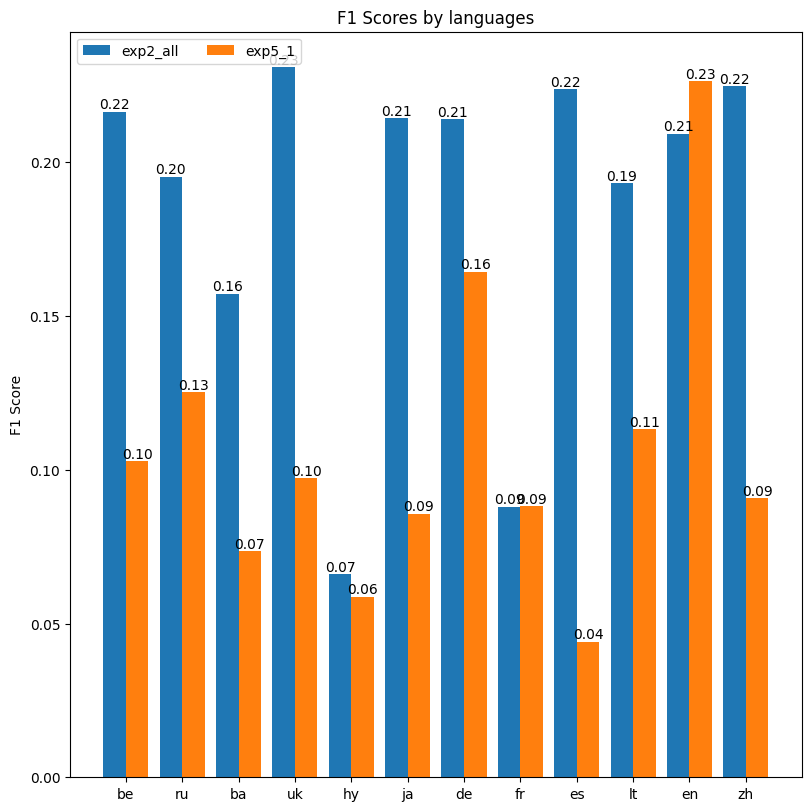

In [70]:
plot({
    "exp2_all": exp2_all_wo_limit,
    "exp5_1": exp5_one_shot
})

Only English exceeds the baseline and most of other languages are left far behind baseline. 

### all languages with linguistic context

Then, we fine-tune mt5-xl on all languages with linguistic context for 100 epochs. 

https://gerbil-qa.aksw.org/gerbil/experiment?id=202305120161

In [71]:
exp5_all_ling = pd.read_csv("../gerbil_results/mt5-xl_11-ling.csv")
exp5_all_ling

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0044,0.0125,0.0027,0.1149,0.1179,0.1236,0.2029
1,be,0.0103,0.0105,0.0102,0.1951,0.2120,0.1938,0.2814
2,de,0.0310,0.0374,0.0265,0.2153,0.2213,0.2201,0.3001
3,en,0.0281,0.0301,0.0263,0.2016,0.2079,0.2003,0.2851
4,es,0.0000,0.0000,0.0000,0.0441,0.0441,0.0441,0.0845
5,fr,0.0111,0.4070,0.0056,0.0880,0.0877,0.0882,0.1611
6,ja,0.0362,0.0573,0.0265,0.2121,0.2226,0.2113,0.2877
7,lt,0.0097,0.0098,0.0097,0.2139,0.2203,0.2204,0.2986
8,ru,0.0093,0.0093,0.0094,0.2059,0.2194,0.2044,0.2861
9,uk,0.0251,0.0221,0.0291,0.1744,0.1913,0.1722,0.2489


Now, we compare this result with our baseline and exp4_all, which is based on mt5-base model to see if a larger pre-trained model performs better. 

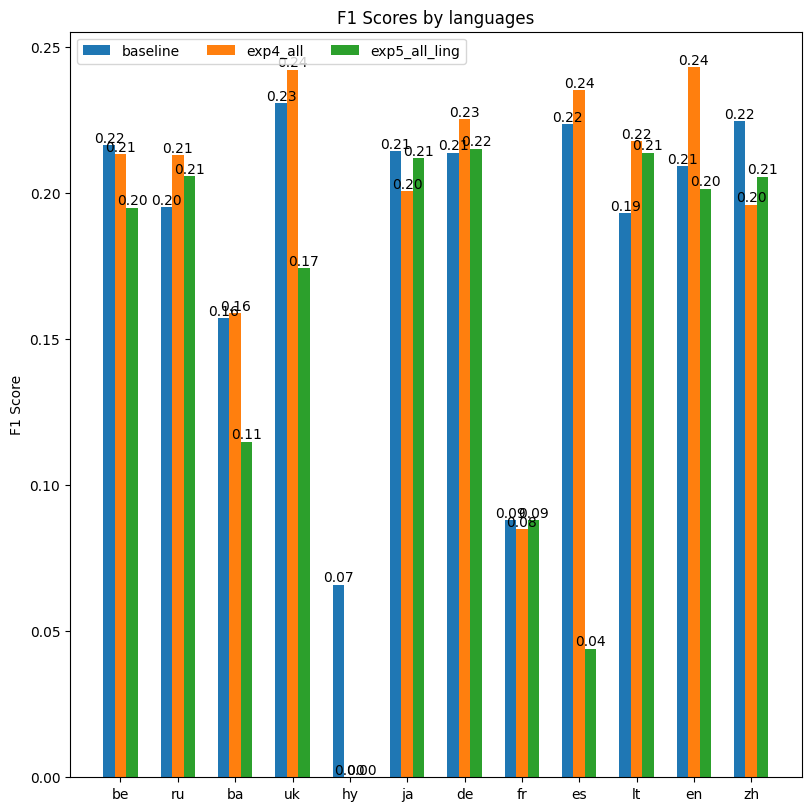

In [73]:
plot({
    "baseline": exp2_all_wo_limit,
    "exp4_all": exp4_all,
    "exp5_all_ling": exp5_all_ling
}, x_distance=2)

Unfortunately, a larger pre-trained model doesn't bring a better preformance. mT5-base model fine-tuned on all languages with linguistic context still has the best result. 

After analysis the predicted SPARQL queries, we find that our fine-tuned model can only predict queries that are already in the train set, which means our model losts the ability of generalization. We have to reduce the number of epochs for fine-tuning to avoid overfitting. Moreover, many questions in test set are out-of-scope from the train set. Our model needs to learn more entities and relations in the wikidata knowledge graph. 

Therefore, we decide to train **mT5-XL** model on LC-QuAD again. But this time, we double the number of epochs, namely **32 epochs**, since for 16 epochs the loss is still high. And we add relation tokens explicitly to the mT5-tokenizer. 

## Experiment 6 



We take our new mT5-XL model pre-trained on LC-QuAD, and fine-tune it again on qald-9-plus dataset. As we know from previous experiments, fine-tuning on all languages brings the best performance on average. So this time we first **fine-tune on all language**. In this experiment, we fine-tune on qald-9-plus for **15 epochs**.

**Keypoints**:

- pre-train on LC-QuAD
    - train for 32 epochs
    - ~~add 3000+ relation tokens from LC-QuAD~~
- fine-tune on qald-9-plus
    - train for 15 epochs
    - use all languages
    - without linguistic context

### mistake experiment

This is our first experiment in this setting. In the pre-train on LC-QuAD phase, but *only two relation tokens are added to the tokenizer* because of an error in the implementation. 
Even though, we fine-tuned it on **qald-9-plus all language questions without linguistic context**, since the LC-QuAD dataset, on which the mT5-XL model is pre-trained, also doesn't have linguistic context. 

In [16]:
exp6_all = pd.read_csv("../gerbil_results/mt5-xl-lcquad-3000rt-mistake.csv")
exp6_all

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0005,0.0003,0.0070,0.1350,0.1441,0.1457,0.2417
1,be,0.0009,0.0005,0.0125,0.2364,0.2385,0.2406,0.3523
2,de,0.0028,0.0015,0.0158,0.2540,0.2555,0.2625,0.3744
3,en,0.0104,0.0079,0.0155,0.2751,0.2766,0.2842,0.4072
4,fr,0.0108,0.4198,0.0055,0.0953,0.0951,0.0956,0.1738
5,ja,0.0008,0.0004,0.0121,0.2339,0.2337,0.2491,0.3559
6,lt,0.0023,0.0012,0.0235,0.2250,0.2247,0.2299,0.3482
7,ru,0.0006,0.0003,0.0086,0.2240,0.2253,0.2332,0.3415
8,uk,0.0006,0.0003,0.0078,0.2434,0.2492,0.2461,0.3629
9,zh,0.0064,0.0052,0.0083,0.2369,0.2366,0.2447,0.3519


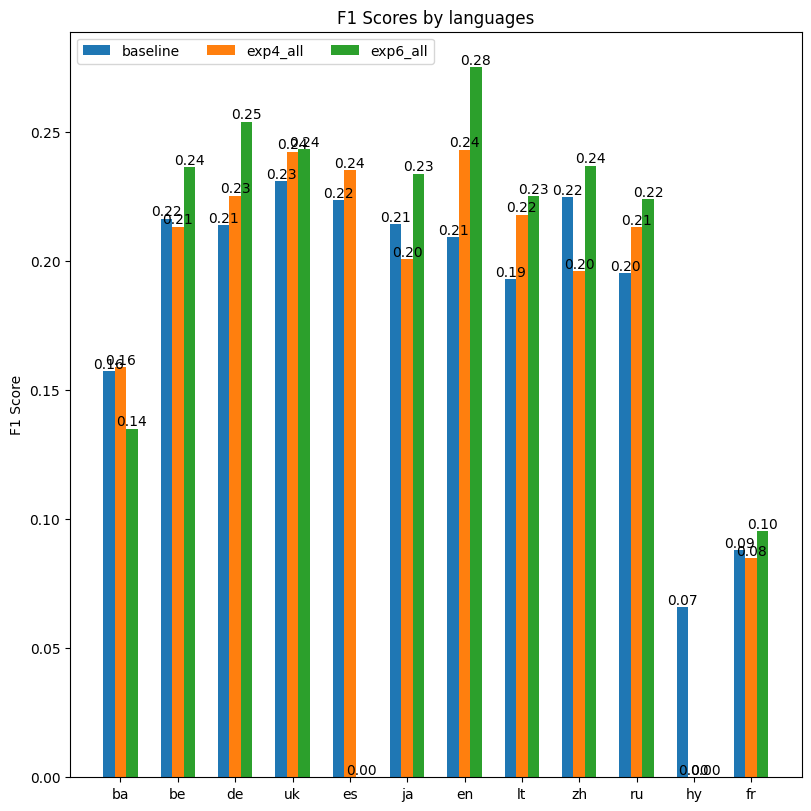

In [17]:
plot({
    "baseline": exp2_all_wo_limit,
    "exp4_all": exp4_all,
    "exp6_all": exp6_all
}, x_distance=2)

This experiment has the best performance so far on average. `hy` and `es` are not in the train set and test set, so that they are not take in account. 8 of 10 languages get a F1-score above 22, while English gets a impressive 27.51 F1-score. 

It remains to do
- Analyse prediction file in this previous experiment.
  - which questions are answered correctly by the new model?
  - how many entities and relations are learned from LC-QuAD?
- Fine-tune on the model, where the relations are added correctly
- Fine-tune with linguistic context

### correct experiment

On this occasion, we have successfully fine-tuned mT5-XL on LC-QuAD and incorporating all relation tokens from LC-QuAD. More than 3000 tokens are added to the mT5 tokenizer. 

We supposed to evaluate our model checkpoint on GERBIL every n steps, however, since some errors appeared during running and are hard to be fixed, we evaluated checkpoints 600, 900, and 1050 for this model. 

In [18]:
exp6_600 = pd.read_csv("../gerbil_results/mt5-xl-lcquad-3000rt-600.csv")
exp6_900 = pd.read_csv("../gerbil_results/mt5-xl-lcquad-3000rt-900.csv")
exp6_1050 = pd.read_csv("../gerbil_results/mt5-xl-lcquad-3000rt-1050.csv")

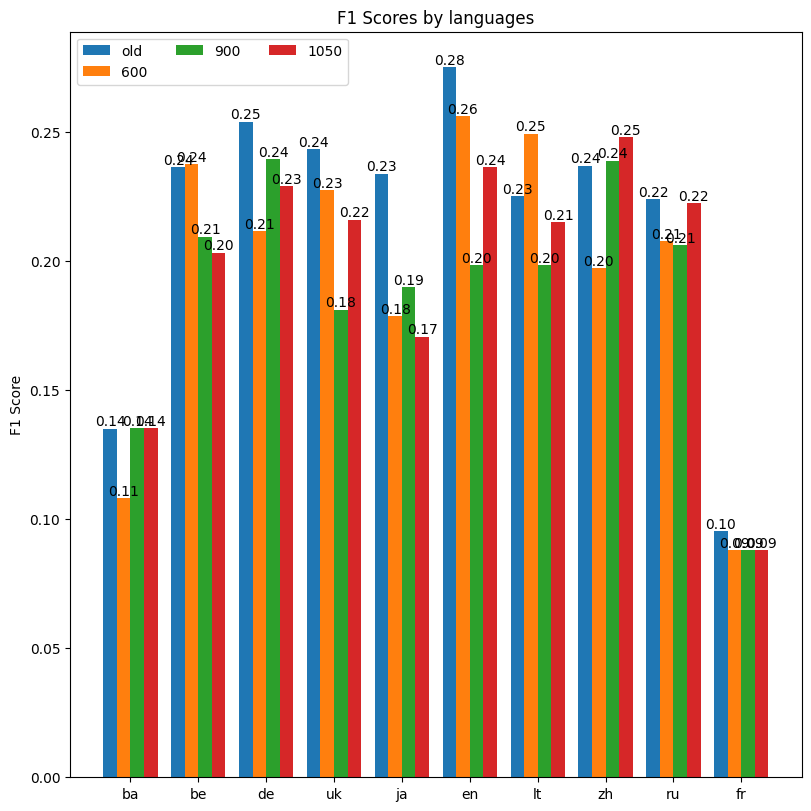

In [19]:
plot({
    "old": exp6_all,
    "600": exp6_600,
    "900": exp6_900,
    "1050": exp6_1050
}, x_distance=2)

We don't see an improvement in performance after adding all relation tokens. 
One of the reasons may be that the training data set is too small for the language model to learn these tokens, which is also mentioned in some other papers. 

In the next experiment, we would decrease the number of tokens to be added to the tokenizer.

## Experiment 7

In this experiment, we filtered relation tokens from LC-QuAD by frequency. By choosing tokens, which appear more than 10 times in LC-QuAD, it remains about 300 tokens. We only added these tokens to the tokenizer. We kept other experiment settings as in [Experiment 6](#experiment-6)

**Keypoints**:

- pre-train on LC-QuAD
    - train for 32 epochs
    - add about 300 relation tokens from LC-QuAD
- fine-tune on qald-9-plus
    - train for 15 epochs
    - use all languages
    - with/without linguistic context

### exp7-wo-ling-context

In [20]:
exp7 = pd.read_csv("../gerbil_results/mt5-xl-lcquad-300rt.csv")
exp7

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0109,0.2177,0.0056,0.1321,0.1329,0.1447,0.2480
1,be,0.0051,0.0108,0.0033,0.1538,0.1585,0.1560,0.2602
2,de,0.0050,0.0066,0.0041,0.1826,0.1836,0.1858,0.3032
3,en,0.0087,0.0066,0.0128,0.1772,0.1804,0.1792,0.2921
4,fr,0.0042,0.7831,0.0021,0.0955,0.0953,0.0956,0.1741
5,ja,0.0280,0.0280,0.0280,0.1739,0.1768,0.1743,0.2869
6,lt,0.0021,0.0024,0.0019,0.1781,0.1870,0.1822,0.2996
7,ru,0.0263,0.0269,0.0257,0.1668,0.1685,0.1724,0.2823
8,uk,0.0275,0.0293,0.0260,0.2125,0.2181,0.2126,0.3390
9,zh,0.0324,0.0591,0.0223,0.1865,0.1881,0.1979,0.3177


### exp7-w-ling-context

In [21]:
exp7_ling = pd.read_csv("../gerbil_results/mt5-xl-lcquad-300rt-ling.csv")
exp7_ling

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0044,0.0131,0.0027,0.1280,0.1377,0.1310,0.2265
1,be,0.0314,0.0382,0.0266,0.1912,0.2074,0.1947,0.3073
2,de,0.0123,0.0160,0.0100,0.2432,0.2523,0.2411,0.3677
3,en,0.0414,0.0512,0.0348,0.2726,0.2819,0.2801,0.4061
4,fr,0.0114,0.6088,0.0057,0.1121,0.1171,0.1115,0.2002
5,ja,0.0093,0.0114,0.0079,0.1947,0.2028,0.2037,0.3136
6,lt,0.0022,0.0013,0.0099,0.1918,0.1937,0.1980,0.3116
7,ru,0.0286,0.0315,0.0262,0.1877,0.1957,0.1881,0.3017
8,uk,0.0349,0.0382,0.0321,0.2067,0.2144,0.2074,0.3236
9,zh,0.0092,0.0115,0.0076,0.1835,0.1852,0.1932,0.3035


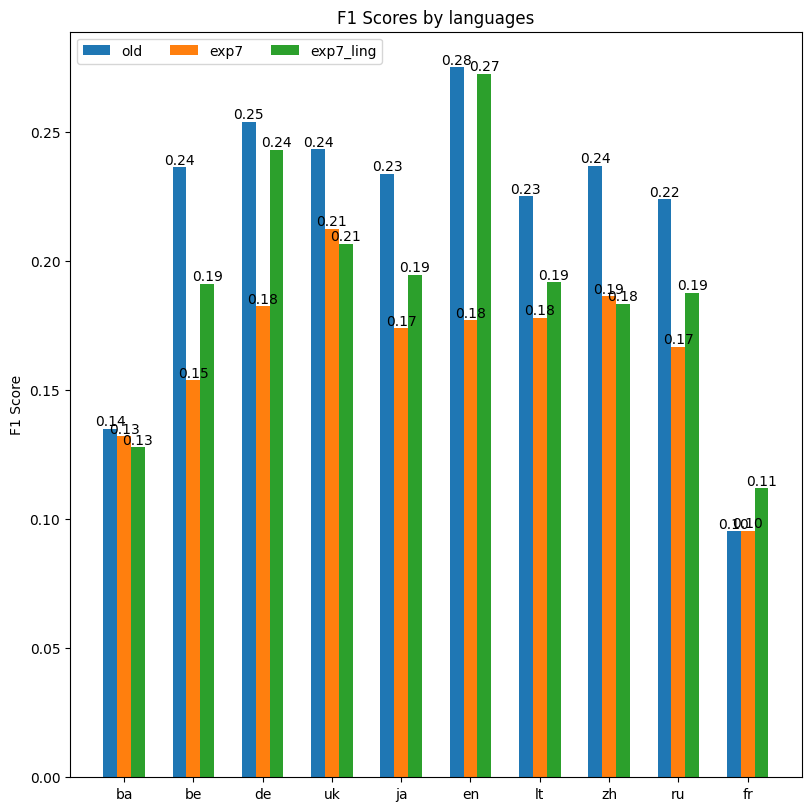

In [22]:
plot({
    "old": exp6_all,
    "exp7": exp7,
    "exp7_ling": exp7_ling,
}, x_distance=2)

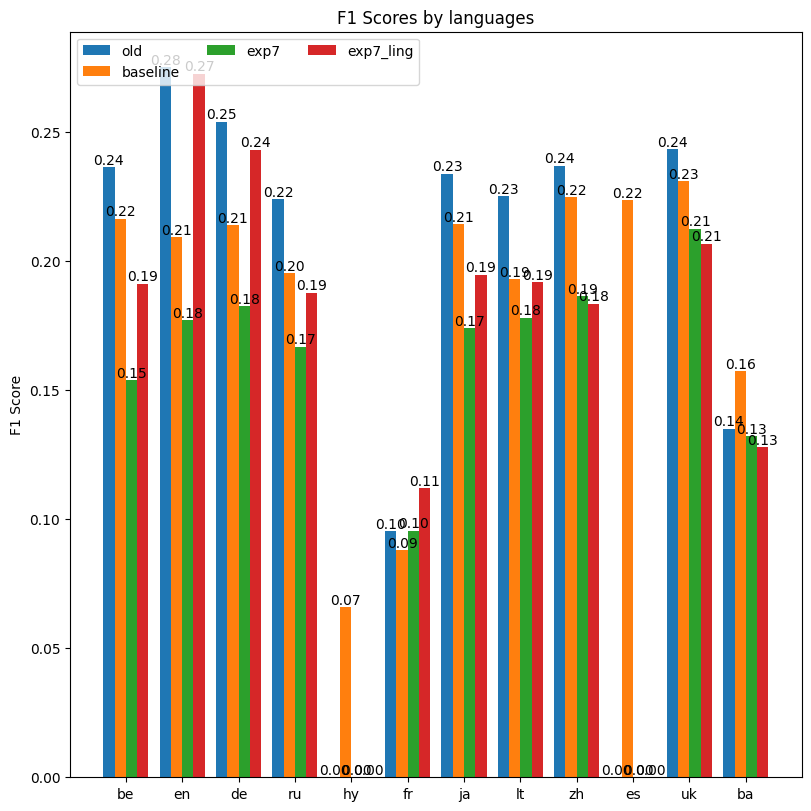

In [9]:
plot({
    "old": exp6_all,
    "baseline": exp2_all_wo_limit,
    "exp7": exp7,
    "exp7_ling": exp7_ling,
}, x_distance=2)

According to the resuls, the mistake experiment in experiment 6, which only added 2 relation tokens by accident, still performs the best. 

We thought it was possible to add 300 tokens for tokenizer is still too much. We may reduce the number of added tokens to 50 or 100.

# New Evaluation Results

Since the knowledge in a knowledge graph is updated everyday, we may also update the answers in our reference file for evaluation. Specifically, we update the answers in the qald-9-plus dataset and reevaluate the previous results. 

We did it for the [mistake experiment](#mistake-experiment), [experiment 7 without linguistic context](#exp7-wo-ling-context), and [experiment 7 with linguistic context](#exp7-w-ling-context). 

The results are impressive. 

In [1]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306220010
exp6= pd.read_csv("../gerbil_results/exp6-mt5xl-lcquad.csv")
exp6

NameError: name 'pd' is not defined

In [ ]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306220012
exp7 = pd.read_csv("../gerbil_results/exp7-mt5xl-lcquad-300rt.csv")
exp7

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0202,0.7279,0.0102,0.2158,0.2286,0.2219,0.3477
1,be,0.0066,0.0038,0.0234,0.2535,0.2657,0.2650,0.3876
2,de,0.0363,0.0364,0.0363,0.3355,0.3479,0.3370,0.4655
3,en,0.0115,0.0069,0.0364,0.3165,0.3316,0.3284,0.4542
4,fr,0.0089,0.5974,0.0045,0.1397,0.1397,0.1397,0.2435
5,ja,0.0038,0.0020,0.0311,0.2519,0.2669,0.2522,0.3666
6,lt,0.0128,0.0166,0.0104,0.2531,0.2589,0.2696,0.3948
7,ru,0.0039,0.0021,0.0310,0.2562,0.2676,0.2635,0.3841
8,uk,0.0029,0.0016,0.0232,0.2433,0.2565,0.2488,0.3677
9,zh,0.0188,0.0155,0.0238,0.2838,0.2905,0.2987,0.4229


In [ ]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306220011
exp7_lc = pd.read_csv("../gerbil_results/exp7-mt5xl-lcquad-300rt-lc.csv")
exp7_lc

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0039,0.0146,0.0023,0.1951,0.2068,0.1998,0.3223
1,be,0.0303,0.0438,0.0231,0.2373,0.2572,0.2415,0.3653
2,de,0.0111,0.0171,0.0082,0.3133,0.3239,0.3161,0.4461
3,en,0.0435,0.0639,0.0330,0.3353,0.3430,0.3427,0.4699
4,fr,0.0089,0.6259,0.0045,0.1397,0.1397,0.1397,0.2443
5,ja,0.0085,0.0122,0.0065,0.2355,0.2455,0.2509,0.3675
6,lt,0.0023,0.0013,0.0081,0.2544,0.2581,0.2672,0.3931
7,ru,0.0143,0.0103,0.0231,0.2636,0.2750,0.2708,0.3952
8,uk,0.0377,0.0483,0.0309,0.2468,0.2522,0.2484,0.3706
9,zh,0.0085,0.0127,0.0064,0.2451,0.2487,0.2608,0.3828


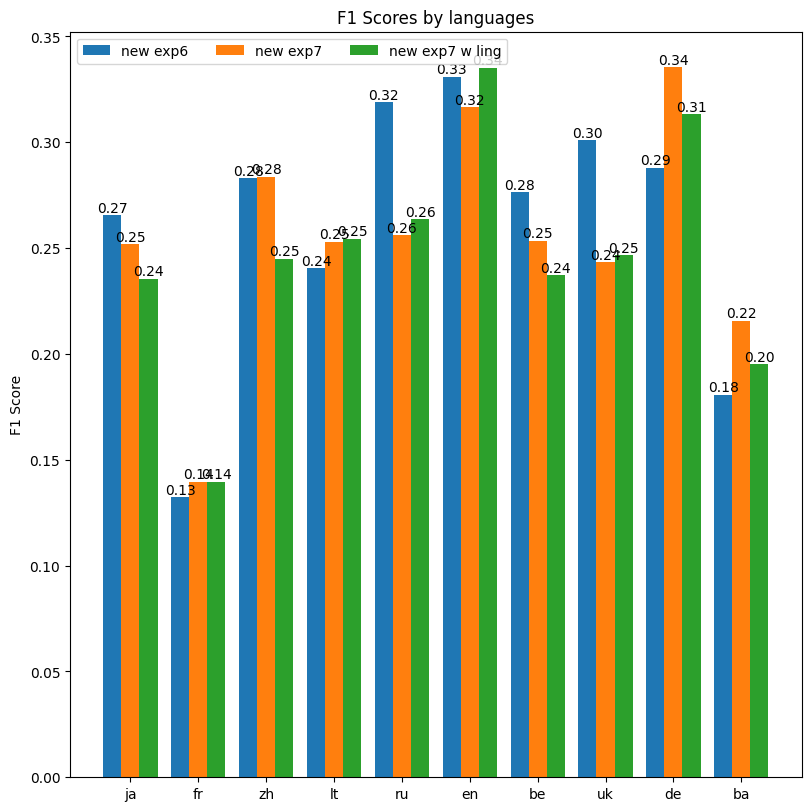

In [ ]:
plot({
    "new exp6": exp6,
    "new exp7": exp7,
    "new exp7 w ling": exp7_lc,
},
x_distance=1.5)

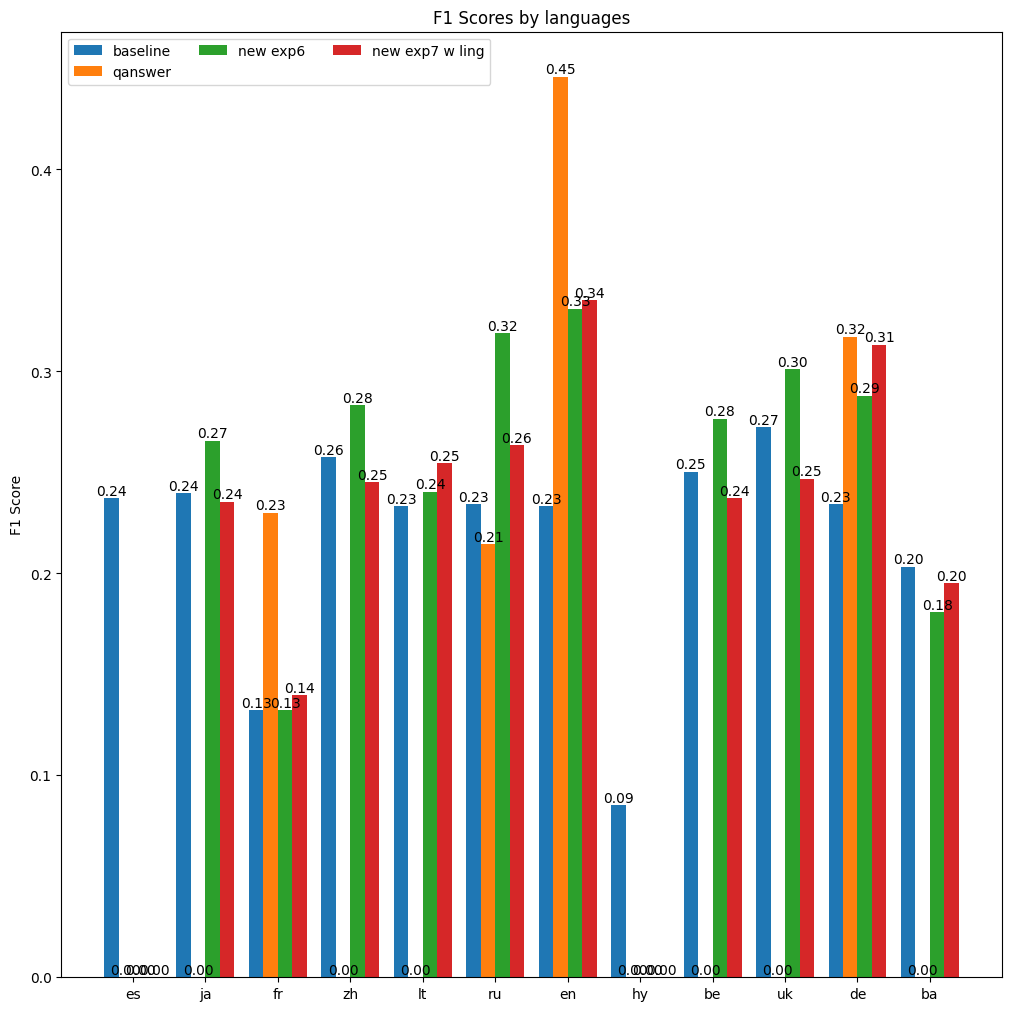

In [ ]:
plot(
    {
        "baseline": baseline,
        "qanswer": qanswer,
        "new exp6": exp6,
        "new exp7 w ling": exp7_lc,
    },
    x_distance=2,
    figsize=(10,10)
)

Clearly, our results from exp7 with linguistic context beat the QAnswer, which is the best performing QA system so far. 

TODO: 
- retrain SGPT on wikidata queries
- evaluate the performance of SGPT on wikidata
- add to top, all previous results and baseline
- compare with exp7/8

## Experiment 8

Since language model gains performance when it get more context from the input, we try to give move knowledge to our language model, to see whether entity knowledge can boost the performance. 

**Keypoints**:

- pre-train on LC-QuAD
    - train for 15 epochs
    - with linguistic context and entity knowledge
- fine-tune on qald-9-plus
    - train for 15 epochs
    - use all languages
    - with linguistic context and entity knowledge 

In evaluation, we add the entity knowledge from reference SPARQLs to the quesiton. In this case, the language model see part of the reference SPARQL, so the results tend to be higher and we call it "cheat". 

In [ ]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306220007
exp8_cheat = pd.read_csv("../gerbil_results/exp8-mt5xl-lcquad-lc-ek-cheat.csv")
exp8_cheat

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0123,0.1821,0.0064,0.2604,0.2652,0.2687,0.4088
1,be,0.2148,0.8504,0.1230,0.4551,0.4751,0.4582,0.6008
2,de,0.1920,0.9001,0.1075,0.4882,0.5036,0.4939,0.6305
3,en,0.1926,0.9037,0.1078,0.5015,0.5159,0.5086,0.6514
4,fr,0.0201,0.9905,0.0101,0.1593,0.1618,0.1581,0.2727
5,ja,0.1804,0.7512,0.1025,0.4375,0.4492,0.4415,0.5820
6,lt,0.1824,0.6986,0.1049,0.4207,0.4388,0.4269,0.5701
7,ru,0.1717,0.4281,0.1074,0.4369,0.4529,0.4351,0.5739
8,uk,0.1295,0.1688,0.1051,0.4519,0.4706,0.4583,0.6033
9,zh,0.1915,0.9059,0.1070,0.4671,0.4782,0.4706,0.6157


Again, we use a entity linking tool to recognize potential entities in the questions and link them to there Wikidata ids, then append them to the question. In this way, our language model doesn't see the reference SPARQL at all. 

In [ ]:
exp8 = pd.read_csv("../gerbil_results/exp8-mt5xl-lcquad-lc-ek.csv")
exp8

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0027,0.0018,0.0052,0.2769,0.2826,0.2943,0.4361
1,be,0.0009,0.0005,0.0075,0.3742,0.3835,0.3942,0.5287
2,de,0.0100,0.0705,0.0054,0.3710,0.3786,0.3824,0.5287
3,en,0.0037,0.0025,0.0077,0.4215,0.4350,0.4548,0.5918
4,es,0.0087,0.0089,0.0085,0.3633,0.3766,0.3753,0.5269
5,fr,0.0037,0.4967,0.0018,0.1375,0.1390,0.1415,0.2475
6,ja,0.0016,0.0009,0.0065,0.3847,0.3983,0.4042,0.5377
7,lt,0.0018,0.0010,0.0070,0.3577,0.3688,0.3788,0.5192
8,ru,0.0086,0.0168,0.0058,0.4122,0.4251,0.4266,0.5749
9,uk,0.0072,0.0068,0.0076,0.3994,0.4130,0.4254,0.5647


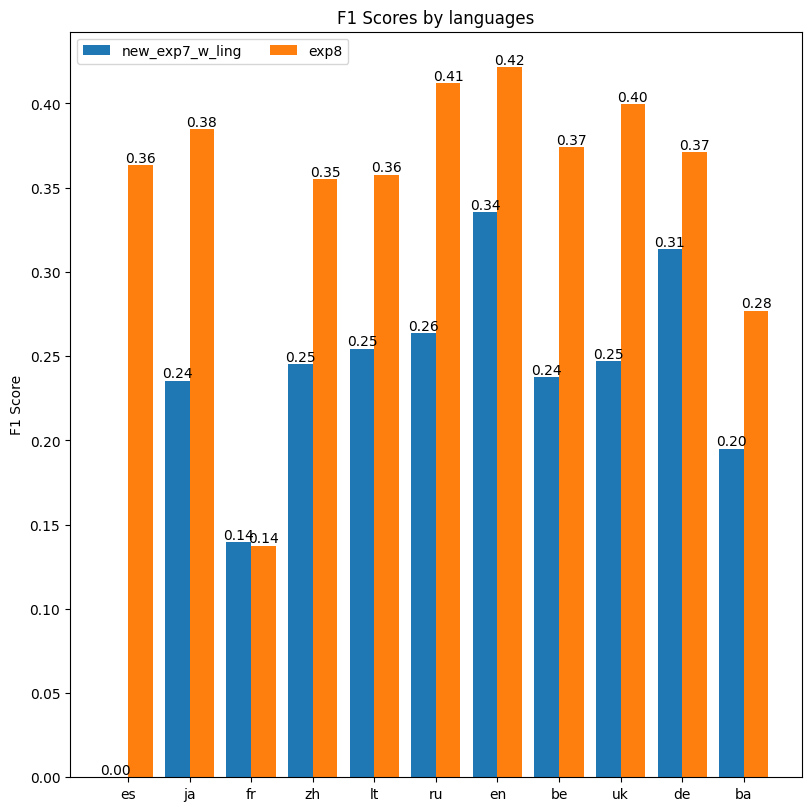

In [ ]:
plot({
    "new_exp7_w_ling": exp7_lc,
    "exp8": exp8
})

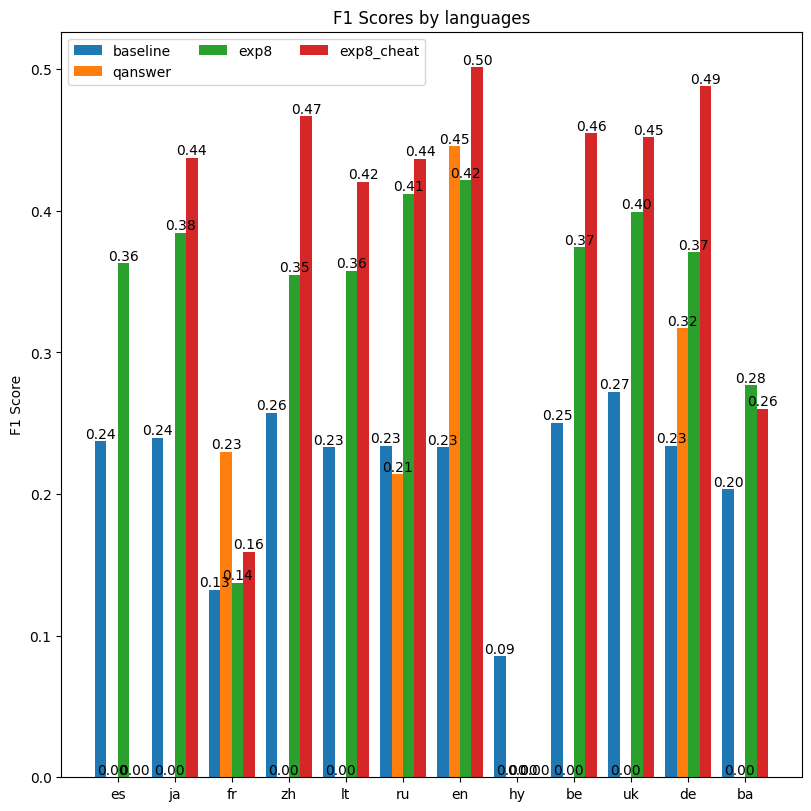

In [ ]:
plot({
    "baseline": baseline,
    "qanswer": qanswer,
    "exp8": exp8,
    "exp8_cheat": exp8_cheat
}, x_distance=2)

exp8_cheat is significantly better than others, since it has all information about the entities in the reference SPARQL. However, not all entities appear in the SPARQLs are mentioned in the question, and the quality of entity linking varies between languages, therefore append entities from refernece SPARQLs is a great benefit for inference. 

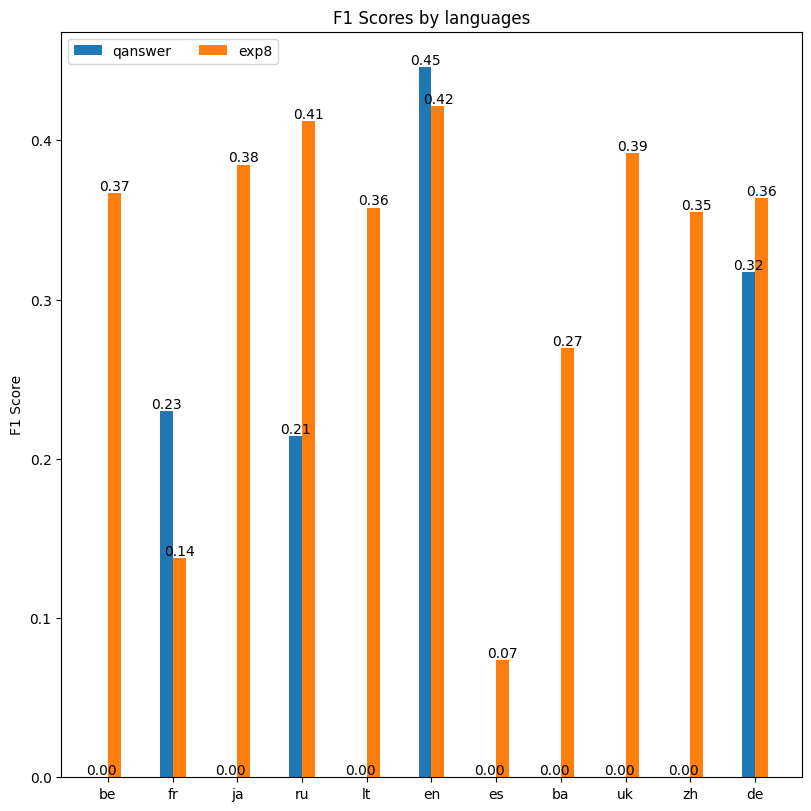

In [ ]:
plot({
    "qanswer": qanswer,
    "exp8": exp8,
}, x_distance=2)

Compare to QAnswer, our results is left behind in `en` and `fr`, but we exceed QAnswer in `de` and `ru`, especially `ru`.

Then, we added `es` to our train and test data set, fine-tuned our model again and evaluated.

## Experiment 9

Since we always pre-train the mT5 model on LC-QuAD without linguistic context, we did this experiment to see whether the performance gets better if we add linguistic context to both pre-training data set and fine-tuning data set. 
Besides, there is no clear comparison for the effect of adding relation tokens from LC-QuAD in pre-training, we did an exp9 which is **without adding relation tokens** and an exp9' which is **with adding relation tokens**. 
From the previous experiment, adding all more than 30k relation tokens is overwhelmed for our language model to learn, so we filtered the tokens by frequency and added the tokens which appear more than 10 times, that are about 300 tokens. 

For these two experiments, we pre-trained mT5-XL on LC-QuAD data set with linguistic context for 32 epochs and fine-tuned on qald-9-plus all languages with linguistic context for 15 epochs. 

In [ ]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306260002
exp9 = pd.read_csv("../gerbil_results/exp9-mt5xl-lcquad-lc.csv")
exp9

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0201,0.4254,0.0103,0.2101,0.2217,0.2219,0.3484
1,be,0.1999,0.4294,0.1303,0.3157,0.3238,0.3282,0.4481
2,de,0.2381,0.4965,0.1566,0.3460,0.3598,0.3552,0.4864
3,en,0.0365,0.0206,0.1571,0.3853,0.4047,0.4029,0.5295
4,fr,0.0089,0.9246,0.0045,0.1397,0.1397,0.1397,0.2440
5,ja,0.0149,0.0078,0.1469,0.3303,0.3387,0.3389,0.4500
6,lt,0.1223,0.1052,0.1459,0.2836,0.2879,0.3049,0.4205
7,ru,0.2366,0.5019,0.1548,0.2923,0.3017,0.3003,0.4214
8,uk,0.2274,0.5005,0.1471,0.3346,0.3440,0.3482,0.4660
9,zh,0.2486,0.8018,0.1471,0.2875,0.2977,0.3009,0.4158


In [ ]:
# https://gerbil-qa.aksw.org/gerbil/experiment?id=202306260000
exp9_300rt = pd.read_csv("../gerbil_results/exp9-mt5xl-lcquad-300rt-lc.csv")
exp9_300rt

,Language,Micro F1,Micro Precision,Micro Recall,Macro F1,Macro Precision,Macro Recall,Macro F1 QALD
0,ba,0.0042,0.0793,0.0022,0.1949,0.2010,0.1937,0.3132
1,be,0.0064,0.0037,0.0234,0.2802,0.2845,0.2965,0.4118
2,de,0.0354,0.0588,0.0254,0.3270,0.3512,0.3315,0.4522
3,en,0.0450,0.0588,0.0364,0.3766,0.3937,0.3754,0.5029
4,fr,0.0090,0.9635,0.0045,0.1495,0.1544,0.1485,0.2576
5,ja,0.2606,0.8115,0.1552,0.2807,0.2866,0.2906,0.4052
6,lt,0.0005,0.0003,0.0081,0.2323,0.2360,0.2448,0.3575
7,ru,0.0088,0.0051,0.0312,0.2635,0.2748,0.2798,0.3951
8,uk,0.0022,0.0011,0.0311,0.2667,0.2769,0.2926,0.4039
9,zh,0.0060,0.0034,0.0269,0.3008,0.3139,0.3196,0.4337


### compare to with additional relation tokens

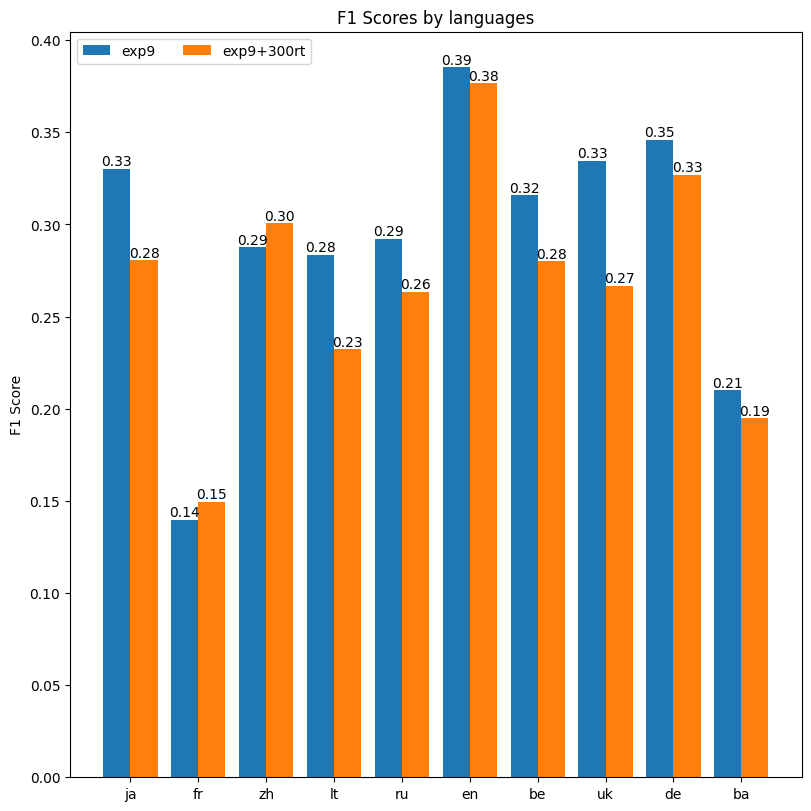

In [ ]:
plot({
    "exp9": exp9,
    "exp9+300rt": exp9_300rt
})

The results shows only `fr` and `zh` benifit a little from the relation tokens.
For other languages, additional relation tokens bring a negative effect. 

The reason could be that the training data set is too small for training new tokens. 
The performance may increase if the training set is larger, 
so the language model can learn the new tokens better.
But, we are not able to get a larger training data set and don't have the resource to train on it. 

On the other hand, even though relation and entity tokens are tokenized to subwords by the tokenizer, the language model still learns the correlation between subwords for a relation or entity token, or a keyword in SPARQL queries. 

- Q: Why only add relation tokens to the tokenizer? Why not try to also add entity tokens into the tokenizer?
- A: According to the Wikidata website, there are currently [11,043 properties](https://www.wikidata.org/wiki/Help:Properties) and [104,572,875 entities](https://www.wikidata.org/wiki/Wikidata:Statistics) in Wikidata. The number of entity tokens are too large in wikidata, we don't have that much training data for our language model to learn additional entity tokens. But, the number of properties is significantly smaller and some relation tokens appear multiple times in the LC-QuAD dataset, we want our language model to learn these relation tokens in the dataset and benifit from them. 

### compare to without linguistic context

Compare to exp6_mistake, which is accidently added only two relation tokens to the tokenizer, which could be ignored, and pre-trained on LC-QuAD without linguistic context, then fine-tuned on qald-9-plus without linguistic context.
The rest of settings is the same as exp9.

This comparison shows the effect of linguistic context.

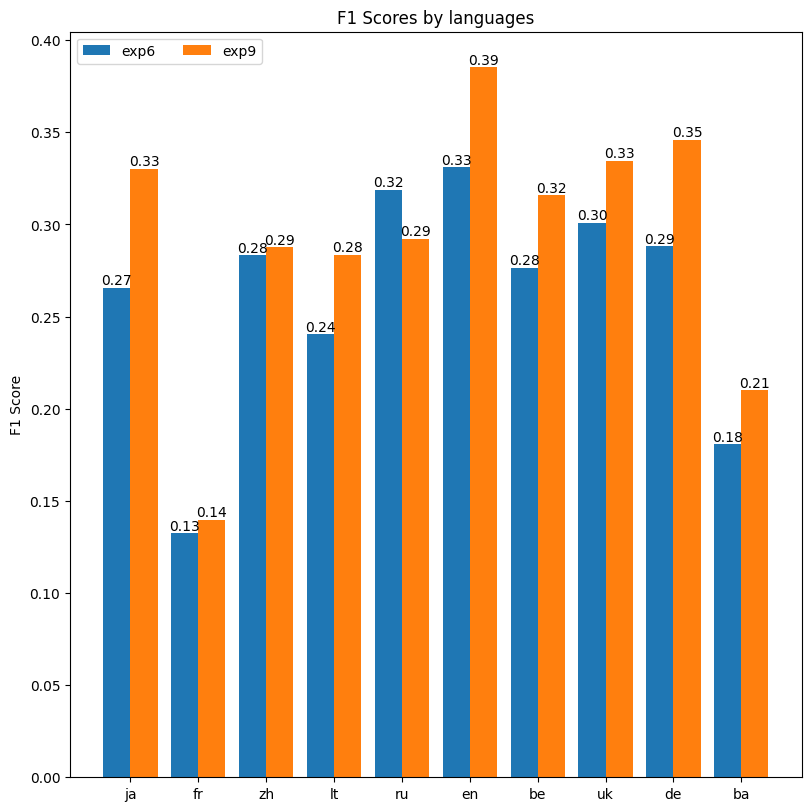

In [ ]:
plot({
    "exp6": exp6,
    "exp9": exp9
})

Clearly, linguistic context brings a positive effect on all languages except `ru`. 
Linguistic context can help the language model to understand the question better.

### compare to with entity knowledge

In [exp8](#experiment-8), except linguistic context, we appended the entity tokens show up in the SPARQL query. 

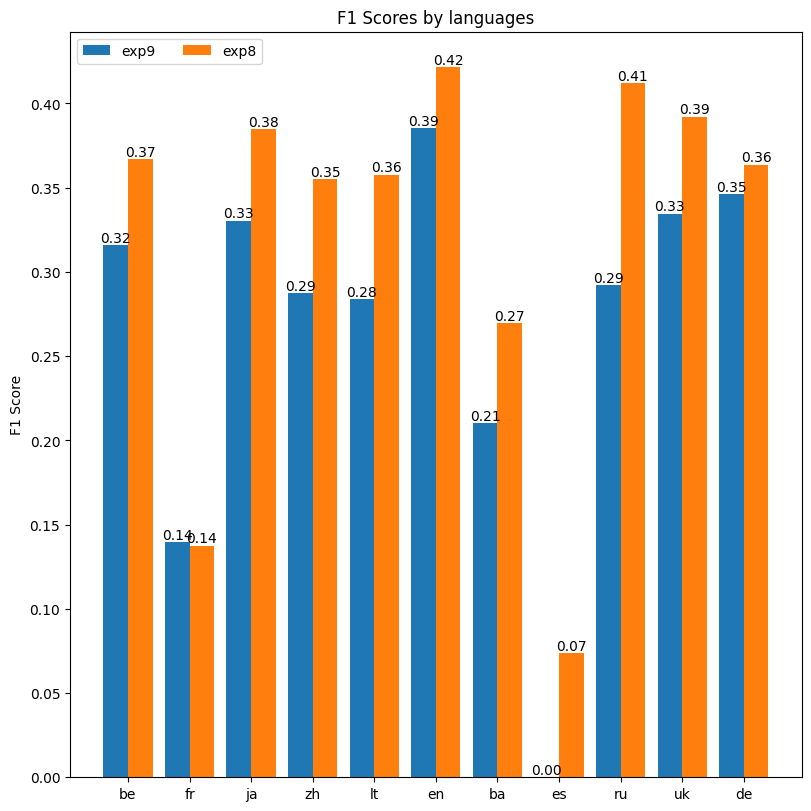

In [ ]:
plot({
    "exp9": exp9,
    "exp8": exp8
})

Experiment 8 exhibits only a marginal inferiority when compared to Experiment 9 in the fr language domain. 
Hence, the incorporation of entity knowledge significantly enhances the language model's ability to accurately predict SPARQL queries.

### compare to baseline and other systems

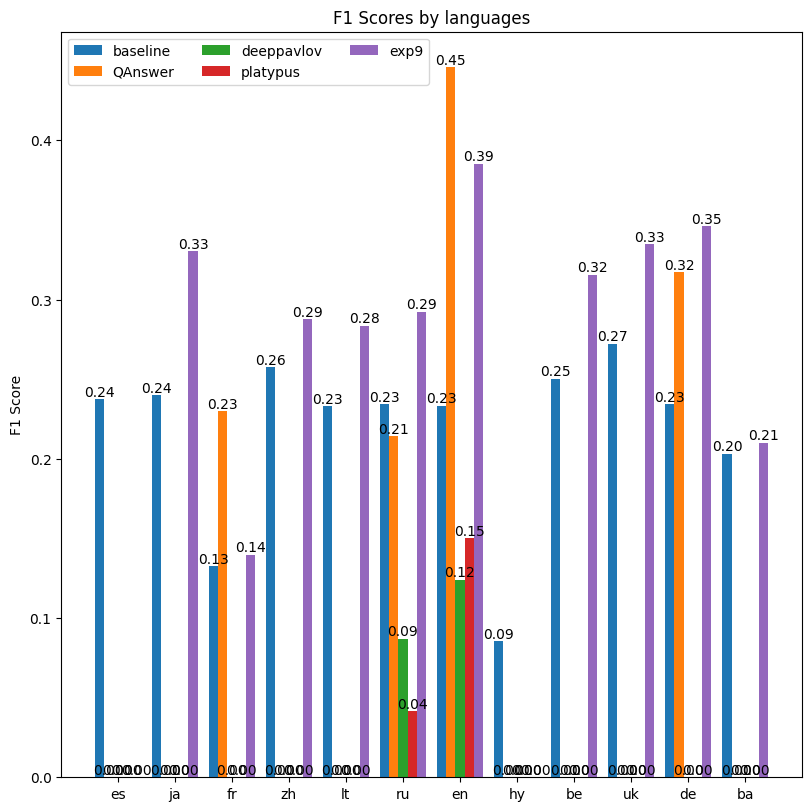

In [ ]:
plot({
    "baseline": baseline,
    "QAnswer": qanswer,
    "deeppavlov": deeppavlov,
    "platypus": platypus,
    "exp9": exp9
}, x_distance=2.5)

Experiment 9 exceeds the baseline significantly for most languages, that shows the positive effect of using a larger language model (baseline uses mT5-base model), pre-train on LC-QuAD to gain more knowledge, and linguistic context. 

Compare to QAnswer, we did better in `de` and `ru`, but worse in `en` and `fr`. 
As for platypus and deeppavlov, we beat them obviously. 